This notebook aims to conduct data-preprocessing steps for our PD Model, specific to machine learning. The following will be conducted. 
- Outlier / Skewness Detection & Treatment 
- Feature Selection (WoE & IV)
- Feature Engineering / Creation 
- Multicollinearity Handling 
- Master Table for PD Production 

# 0. Import Libraries 

In [1]:

# Initialise spark session 
from init_spark import start_spark
spark = start_spark()


# Data manipulation 
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, when, count, desc, isnan, isnull, lit, length, trim, lower, upper, to_date, concat_ws,  regexp_extract, sum , unix_timestamp, from_unixtime
)

from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, IntegerType, DateType, NumericType
)

from pyspark.sql import DataFrame
from datetime import date


# Machine Learning part 
from optbinning import BinningProcess
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd 

# Wandb for logging & checking model performance at each data preprocessing stage 
import os 
import wandb
from dotenv import load_dotenv
wandb.login(key=os.getenv("WANDB_API_KEY"))

# Remove all runs in the project at the start of notebook 
api = wandb.Api()
for run in api.runs(f"wlunlun1212-singapore-management-university/Credit Risk Modeling"):
    run.delete()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/20 22:48:03 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/07/20 22:48:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/lunlun/.ivy2.5.2/cache
The jars for the packages stored in: /Users/lunlun/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6427a6e1-b15d-452f-904c-84c381ccc1ba;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: 

4.0.0


wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Obtain from Gold Medallion Architecture 
df = spark.read.format("delta")\
    .load("../data/gold/medallion_cleaned_lc_data_b4_model").cache()
    
df.limit(5).toPandas()

25/07/20 22:48:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Before we continue on with data preprocessing, we should ensure that in each stage of our data preprocessing, our train and test dataset has ample proportion of defaults. As such, we shall conduct out of time split with column `issue_d` right from the start and inspect the proportion of defaulted loans vs non-defaulted loans of our train dataset and test dataset. 

After running the code below, it seems like the train and test datasets have ample defaulted loans for us to work on. Normally, credit risk model datasets have only 200 - 500 defaulters. However, ~8000 defaulters is enough for us to train our model and test its performance accurately. 

In [ ]:
# 1) Convert to numeric timestamp
df_ts = df.withColumn("issue_ts", unix_timestamp(col("issue_d")))

# 2) Compute the 7th percentile of that timestamp
quantiles = df_ts.approxQuantile("issue_ts", [0.7], 0.01)
cut_ts = quantiles[0]  # e.g. 1672531200

# 3) Convert back to a human date
cut_date = (
    df_ts
    .select(from_unixtime(lit(cut_ts), "yyyy-MM-dd").alias("cut_date"))
    .first()["cut_date"]
)

print(f"Splitting at ≈ {cut_date} ... ")

# 4) Train-test split
train_df = df.filter(col("issue_d") < cut_date) # train using 80% of the data before cut-off data at 80% 
test_df  = df.filter(col("issue_d") >= cut_date)
df = df.withColumn('issue_d', to_date(col('issue_d'), "yyyy-MM-dd"))
df = df.orderBy(col('issue_d').asc())
train_df = df.where(  col('issue_d') <  cut_date   )
test_df = df.where(  col('issue_d') >=  cut_date     )

print("Train Dataset Proportion:")
train_df.groupBy(col('default_status')).count().show()

print("Test Dataset Proportion:")
test_df.groupBy(col('default_status')).count().show()

Splitting at ≈ 2017-07-01 ... 
Train Dataset Proportion:
+--------------+-------+
|default_status|  count|
+--------------+-------+
|             1| 240531|
|             0|1262528|
+--------------+-------+

Test Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1| 26525|
|             0|691624|
+--------------+------+



In [ ]:
# Functions for common workflows for training model at each checkpoint 

from pyspark.sql import DataFrame
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import expr


def sample_and_order(
    initial_df: DataFrame, # Spark df 
    sample_frac: float,
    date_col: str = 'issue_d'
) -> DataFrame:
    """
    Returns sampled data, with data ordered by the specified date column.
    """
    df = initial_df.sample(withReplacement=False, fraction=sample_frac, seed=42).cache()
    df = df.withColumn(date_col, to_date(col(date_col), "yyyy-MM-dd"))
    df = df.orderBy(col(date_col).asc())
    return df

def oot_train_test_split(
    initial_df: DataFrame, 
    date_cut_off: str
) -> tuple [DataFrame, DataFrame]: 
    """
    Conducts out-of-time split according to issue_d column, returning (train_df , test_df) 
    """
    initial_df= initial_df.withColumn('issue_d', to_date(col('issue_d'), "yyyy-MM-dd"))
    initial_df = initial_df.orderBy(col('issue_d').asc())
    train_df = initial_df.where(  col('issue_d') <  to_date(lit(date_cut_off)     )) 
    test_df = initial_df.where(  col('issue_d') >=  to_date(lit(date_cut_off)    )) 
    
    return (train_df, test_df)

def add_class_weightage_cols(train_df) -> DataFrame: 
    """
    Implement same logic as 'balanced' class in sklearn (give more importance to rare class during training)
    
    Adds class_weight column to TRAIN_DATASET 
    """
    
    # Count examples in each class
    major_count = train_df.filter(train_df.default_status == 0).count()
    minor_count = train_df.filter(train_df.default_status == 1).count()
    total_count = train_df.count()

    # Calculate weights (inverse frequency)
    weight_for_0 = total_count / (2 * major_count)
    weight_for_1 = total_count / (2 * minor_count)

    # Add a column for sample weights
    train_df = train_df.withColumn(
        "class_weight_col",
        F.when(train_df.default_status == 0, weight_for_0).otherwise(weight_for_1)
    )
    
    return train_df

def build_one_hot_encoding_pipeline(df): 
    """
    Turns all categories (<string_type>) into one_hot_encoded columns and returns Spark DataFrame
    """
    cat_features = [feature.name for feature in df.schema.fields if isinstance(feature.dataType, StringType)]

    # Create stages for Pipeline: Indexers + Encoders
    stages = []
    for cat_feature in cat_features:
        # StringIndexer stage
        if df.select(cat_feature).distinct().count() > 1:
            indexer = StringIndexer(inputCol=cat_feature, outputCol=f"{cat_feature}_idx")
            # OneHotEncoder stage (uses indexer's output)
            encoder = OneHotEncoder(inputCol=f"{cat_feature}_idx", outputCol=f"{cat_feature}_one_hot_encoded", dropLast=True)
            stages.extend([indexer, encoder])
    
    return Pipeline(stages=stages)


# Log and Evaluate Temporary Results (Each data preprocessing step)
def run_model_checkpoint(df, name, date_cutoff, sample_proportion, model_type): 
    """
        Takes in Spark Dataframe & conducts necessary steps to train a Logistic Regression model quickly (Aim: Evaluate model performance quickly to 
        figure out decrease in model performance) 

        Input Param: 
        - name: logistic_regression_base_features / similar naming after preprocessing steps 
        - date_cutoff: 2018-01-01 by default
        - model_type: 'logistic_regression' by default, but can be xgboost, lightgbm and others ... 
    """
    
    # 1. Start a run (preprocessing step) ... (just set a new name when i run)
    wandb.init(entity='wlunlun1212-singapore-management-university', 
           project='Credit Risk Modeling', 
           name=name,  #! change to logistic_regression_base_features b4 rest of the preprocessing steps 
           )
    
    sampled_df = sample_and_order(df, sample_proportion)
    train_df, test_df = oot_train_test_split(sampled_df, date_cutoff)
    train_weighted_df = add_class_weightage_cols(train_df)
    test_weighted_df = test_df.withColumn("class_weight_col", lit(1.0))  #! Ensure test_df has class_weight_col for consistency, even if it is not used in evaluation (weight column is not read in evaluation)
    
    
    # 2. Ensure train_df can be fed into LR_Model with 'features' vector column, 'class_weight_col' weightCol, 'default_status' label column 
    excluded_cols = ['id', 'issue_d', 'default_status', 'class_weight_col', 'earliest_cr_line'] # exclude date columns, target columns, id for features
    
    
    # 2a. One-Hot Encode both train & test datasets if there are categorical features, b4 fitting into Vector Assembler: one-hot-encoder should only see train data, and not test data
    cat_features = [feature.name for feature in train_df.schema.fields if isinstance(feature.dataType, StringType)]
    
    # Ensure that the categorical features are not empty, otherwise skip one-hot encoding
    if len(cat_features) > 0: 
        ohe_pipeline = build_one_hot_encoding_pipeline(train_weighted_df) # create pipeline object, which has StringIndexer + OneHotEncoder stages, i.e. 
            # Pipeline(stages=[
            # StringIndexer(inputCol='grade',           outputCol='grade_idx',           handleInvalid='keep'),
            # OneHotEncoder(inputCol='grade_idx',       outputCol='grade_ohe',           dropLast=True),
            # StringIndexer(inputCol='home_ownership',  outputCol='home_ownership_idx',  handleInvalid='keep'),
            # OneHotEncoder(inputCol='home_ownership_idx',
            #             outputCol='home_ownership_ohe',
            #             dropLast=True)
            # ])
        ohe_model = ohe_pipeline.fit(train_weighted_df) # schedule of Stringindexers + Onehotencoders 
        train_encoded_df = ohe_model.transform(train_weighted_df).cache() 
        test_encoded_df = ohe_model.transform(test_weighted_df)
        
        idx_cols = [f"{cat}_idx" for cat in cat_features] 
        train_encoded_df = train_encoded_df.drop(*idx_cols) # drop index columns created by StringIndexer
        test_encoded_df = test_encoded_df.drop(*idx_cols)  # drop index columns created by StringIndexer
        
    else: 
        train_encoded_df = train_weighted_df.cache() 
        test_encoded_df = test_weighted_df
        
    feature_cols = [
        f.name
        for f in train_encoded_df.schema.fields
        if (
            (isinstance(f.dataType, NumericType) or isinstance(f.dataType, VectorUDT)) # VectorUDT datatype of one-hot-encoded column
            and f.name not in excluded_cols
            and not f.name.endswith("_idx")          # skip index columns created by StringIndexer 
        )
    ]
        
    vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    # 3. Feed Vectors, Label, Class into Logistic Regression Model (Excludes idx from features ... )
    lr = LogisticRegression(
        featuresCol="features", 
        labelCol="default_status", 
        weightCol="class_weight_col", 
        regParam=0.01 #! Lower values mean potential to overfit more on training data ... 
    )

    pipeline = Pipeline(stages=[vector_assembler, lr])
    trained_lr_model = pipeline.fit(train_encoded_df)
    train_encoded_df.unpersist() # release memory 


    # 4. Predict 
    preds = trained_lr_model.transform(test_encoded_df).cache() 

    
    # Example of preds: (contains original columns + model_output )
    # income | dti | ... | features | prediction | probability |	rawPrediction
    # 1000 | 0.99 |  [0.1, 1.5, 2.4, ...]	| 1.0	| [0.21, 0.79]	| [-1.32, 1.32]
    
    
    # 5. Gini Coefficient 
    evaluator_bin = BinaryClassificationEvaluator(
        labelCol="default_status", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    auc = evaluator_bin.evaluate(preds) # materialises cache of 'preds' -> any subsequent read of 'preds' is from memory 
    gini = 2 * auc - 1
    
    # 6. Obtain confusion matrix related metrics for model performance logging 
    evaluator_multi = MulticlassClassificationEvaluator(labelCol="default_status", predictionCol="prediction")
    f1 = evaluator_multi.setMetricName("f1").evaluate(preds)
    precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(preds)
    recall = evaluator_multi.setMetricName("weightedRecall").evaluate(preds)
    accuracy = evaluator_multi.setMetricName("accuracy").evaluate(preds)

    # 7. Get parameters for Wandb Confusion Matrix 

    rows = preds.select('default_status', 'prediction').collect()
    y_actual = [row['default_status'] for row in rows]
    y_pred = [row['prediction'] for row in rows]

    
    # 8. Log to W&B
    wandb.log({
        "Model Type": model_type,
        "Gini": gini,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": wandb.plot.confusion_matrix(
            y_true=y_actual, preds=y_pred, class_names=["Non-Default", "Default"])
    })

    wandb.finish()


Now, before any data preprocessing steps, let's observe the expected model performance upon throwing all base & raw features. 

In [ ]:
# Current_df has categorical features 
run_model_checkpoint(df=df, name='logistic_regression_raw_features', date_cutoff='2017-08-01', sample_proportion=0.05, model_type='logistic_regression_v1.1')


25/07/20 22:30:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.99475
F1 Score,0.99487
Gini,0.99837
Model Type,logistic_regression_...
Precision,0.99515
Recall,0.99475



![raw](../images/conf_matrix_raw2.png)
![raw2](../images/conf_matrix_raw.png)

As we can see from the image, it seems that we have **overinflated metrics**. The **Gini coefficient is 0.9989**. In comparison to the industry standard, which specifies that a **Gini Coefficient > 0.6 is counted as decent**, and near to 1 values are nearly perfect, this signals to us that our preprocessed dataset has data leakage (i.e our future model peeks into answers). This makes absolute sense as well, given that we have not dropped post loan origination features, and haven't done outlier handling, and feature engineering etc. Furthermore, it seems our other metrics performed too well, if benchmarked against the industry as well. For example, a Recall of 0.996 means that out of all actual defaulted loans, the Logisitic Reegression model predicted 99% of them correctly. This is unrealistic and signals high data leakage. 

# 1. Outlier & Skewness Detection & Treatment 


### 1.0 Mitigate Data Leak 
In credit risk modeling, there are normally features in the dataset, which 'tells our model' the answer, when it should not. Put simply, these are features that hint to the model that the borrower has defaulted in the corresponding record. This is termed as 'data leak' in the data realm and should not happen, since machine learning models are meant to predict the future, using past data. Similarly, we are trying to utilise features known at the time of loan origination, to predict a borrower's / loan's probability of default. As such, let's drop such features right from the start which aren't useful for PD Modeling. An example would be how `grade` is assigned to a loan, after Lending Club has evaluated a borrower's fico score, income, dti etc. 

In [ ]:
post_loan_origination_features = ['int_rate', 'funded_amnt', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt'
                                  , 'last_fico_range_high', 'last_fico_range_low']


# total_pymnt_inv, total_rec_prncp_inv, total_rec_int_inv, out_prncp_inv, 


df = df.drop(*post_loan_origination_features) 
print('✅ Post Loan Origination Features Dropped ...')

run_model_checkpoint(df=df, name='log_reg_dropped_post_loan_ori_features', date_cutoff='2017-08-01', sample_proportion=0.05, model_type='logistic_regression_v1.2')

✅ Post Loan Origination Features Dropped ...


Accuracy,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.70887
F1 Score,0.80107
Gini,0.4253
Model Type,logistic_regression_...
Precision,0.9488
Recall,0.70887


In [ ]:
nihao = df.limit(5).toPandas()
nihao

,id,loan_amnt,term,installment,grade,home_ownership,annual_inc,verification_status,issue_d,default_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,87023,7500.0,36,255.43,E,OWN,22000.0,Not Verified,2007-06-01,0,...,0.0,2.0,100.0,37.5,0.0,0.0,113149.0,37781.0,16300.0,32500.0
1,90376,5000.0,36,155.38,A,MORTGAGE,200000.0,Not Verified,2007-07-01,0,...,0.0,2.0,100.0,37.5,0.0,0.0,113149.0,37781.0,16300.0,32500.0
2,96844,5300.0,36,167.02,A,MORTGAGE,74000.0,Not Verified,2007-07-01,0,...,0.0,2.0,100.0,37.5,0.0,0.0,113149.0,37781.0,16300.0,32500.0
3,96350,5000.0,36,164.23,C,OWN,30000.0,Not Verified,2007-07-01,0,...,0.0,2.0,100.0,37.5,0.0,0.0,113149.0,37781.0,16300.0,32500.0
4,107136,12250.0,36,398.69,C,RENT,60000.0,Not Verified,2007-07-01,0,...,0.0,2.0,100.0,37.5,0.0,0.0,113149.0,37781.0,16300.0,32500.0


### 1.1 Outlier & Skewness Detection 

Before feature engineering, we will be dealing with outliers and skewed distributions, which can distort credit risk models. They can dominate learning, causing bias or overfitting in our PD Model. Let's first identify features which are highly skewed. 

#### 1.1.1 Columns with Outliers 
Upon identifying highly skewed variables in our dataset, it seems we have some absurdly skewed variables. To investigate further, we will first be using `approxQuantile()` method, which is a relatively more computational effective way to identify outliers for big data. This shall be used in computing the % of outliers of these columns. We will be using the IQR method in detecting outliers. 

In [ ]:
def compute_outlier_pct(df, col_name, lower_pct=0.25, upper_pct=0.75):
    '''Computes pct of outliers per column based on IQR method '''
    
    # 1. Compute percentile bounds
    quantiles = df.approxQuantile(col_name, [lower_pct, upper_pct], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1 

    # 2. Obtain lower and upper bound, any data points outside of this are seen as outliers 
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    total_rows = df.count()

    return round(df.filter( (col(col_name) < lower_bound) | (col(col_name) > upper_bound) ).count() / total_rows * 100, 2) 

# 1. After cleaning missing values, find % outliers per column (sampling big data for efficiency)
sample_df = df.select([feature.name for feature in df.schema if isinstance(feature.dataType, NumericType)]).sample(fraction=0.05, seed=42) 


outliers_dict = {}

for feature in sample_df.schema: 
    col_name = feature.name 
    data_type = feature.dataType

    if isinstance(data_type, (DoubleType, IntegerType)): 
        outlier_pct = compute_outlier_pct(sample_df, col_name) 
        if outlier_pct > 0: 
            outliers_dict[col_name] = outlier_pct


print('❌ Outlier Percentage by Feature (sorted):')
for k, v in sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {round(v, 2)}%")


❌ Outlier Percentage by Feature (sorted):
num_accts_ever_120_pd: 22.24%
delinq_2yrs: 18.65%
pub_rec: 15.95%
default_status: 12.08%
pub_rec_bankruptcies: 11.97%
mths_since_recent_bc: 9.12%
bc_open_to_buy: 8.97%
mo_sin_rcnt_rev_tl_op: 8.28%
pct_tl_nvr_dlq: 7.42%
mo_sin_rcnt_tl: 6.64%
total_bal_ex_mort: 6.47%
total_rev_hi_lim: 6.42%
revol_bal: 6.35%
total_bc_limit: 6.31%
avg_cur_bal: 6.1%
total_il_high_credit_limit: 5.63%
annual_inc: 5.39%
mo_sin_old_il_acct: 5.36%
mths_since_recent_inq: 5.32%
num_tl_90g_dpd_24m: 5.13%
num_bc_sats: 4.78%
num_il_tl: 4.34%
num_op_rev_tl: 4.29%
tot_cur_bal: 4.16%
mort_acc: 4.15%
inq_last_6mths: 4.04%
tot_hi_cred_lim: 4.01%
open_acc: 3.73%
num_sats: 3.63%
installment: 3.54%
fico_range_low: 3.44%
fico_range_high: 3.44%
mo_sin_old_rev_tl_op: 3.36%
tax_liens: 2.91%
num_actv_rev_tl: 2.88%
num_rev_tl_bal_gt_0: 2.63%
num_rev_accts: 2.55%
num_tl_op_past_12m: 2.42%
num_bc_tl: 2.37%
num_actv_bc_tl: 2.36%
acc_open_past_24mths: 2.1%
total_acc: 1.72%
collections_12_mths_

To ensure that our WoE & IV Feature Selection produce better binning (more balanced bins) and smoother WoE (if a feature separates good and bad outcomes properly), we should visualise our distributions to understand our dataset better. 

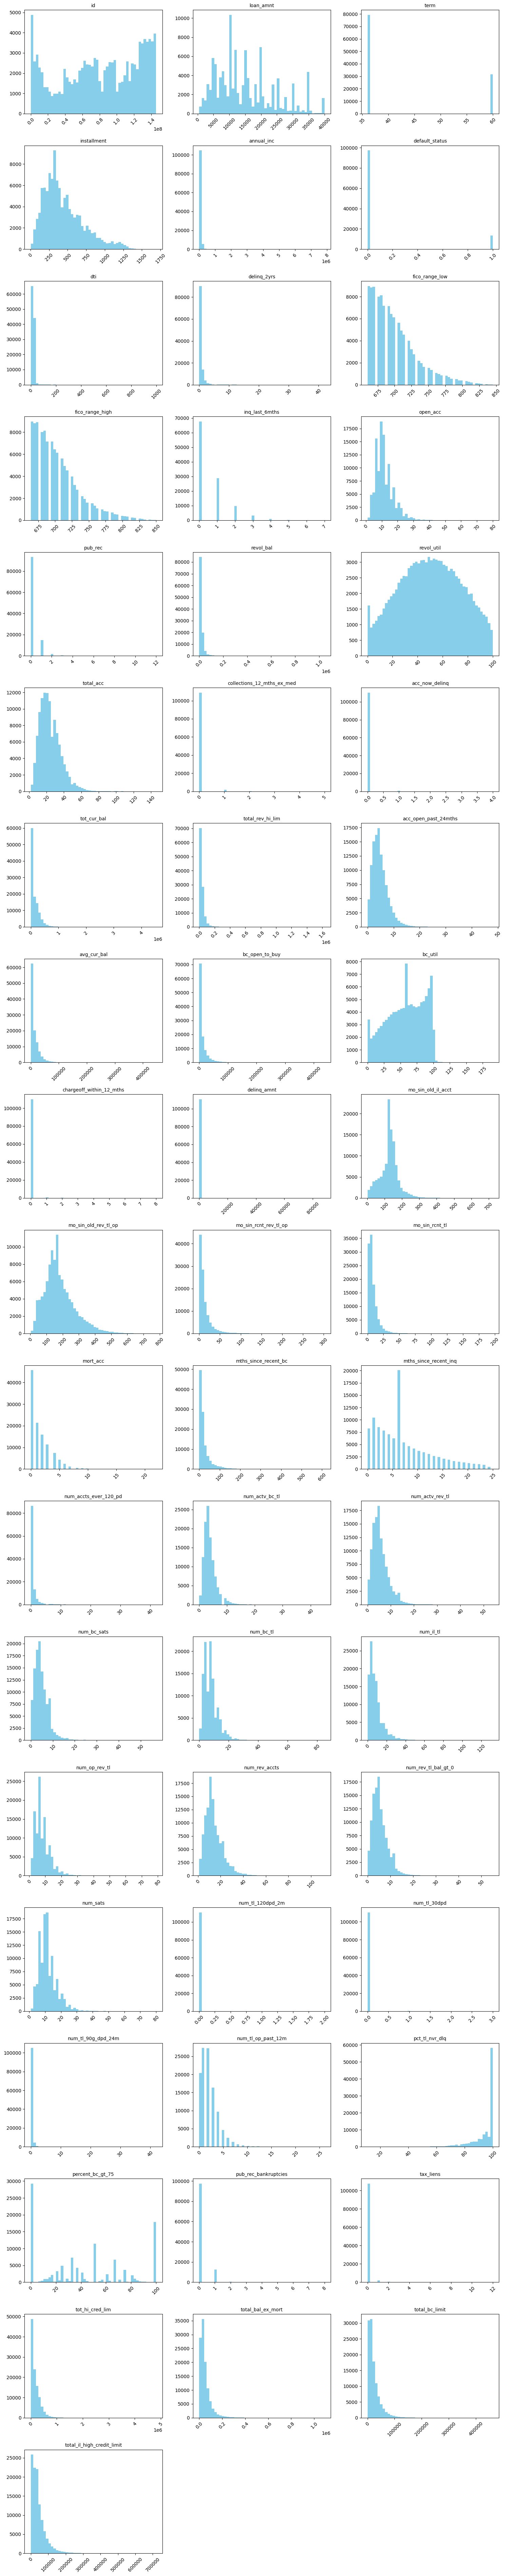

In [ ]:
# 5. Check INITIAL DISTRIBUTION OF NUMERICAL FEATURES 

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import NumericType

def display_distributions(df): 

    # 1. Select numerical columns
    numeric_cols = [field.name for field in df.schema if isinstance(field.dataType, NumericType)]

    # 2. Sample small portion of data (e.g., 5%) and convert to pandas
    sample_df = df.select(numeric_cols).sample(fraction=0.05, seed=42)
    sample_pdf = sample_df.toPandas()

    # 3. Plot histograms as subplots
    n_cols = 3  # Number of plots per row
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col_name in enumerate(numeric_cols):
        axes[i].hist(sample_pdf[col_name].dropna(), bins=50, color='skyblue')
        axes[i].set_title(col_name, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
display_distributions(df)

From the original distribution of our cleaned dataset, we can observe that we have many skewed features, which is common is credit risk datasets. Before dealing with skewness, it is important to handle outliers first. Skewness measures the symmetry of a feature, and a few outliers can over-inflate the skewness of a feature, rendering the skewness value inaccurate. This can lead to us blindly applying transformations to a feature, when it does harm to our PD Model. 

As such, based on the nature of an outlier, they will be dealt in different ways. 
- **Clear Data Error**: Trim 
- **Real Outlier but Rare (Domain Knowledge Based)**: Winsorise till IQR Bounds 
- **Outlier is Real & Meaningful** : Let WoE binning handle this outlier 

In [ ]:
from pyspark.sql import DataFrame
def inspect_outliers_iqr(df: DataFrame, columns: list, sample_size: int = 5):
    for col_name in columns:
        try:
            print(f"\n📊 Inspecting Outliers for Column: `{col_name}`")

            # Step 1: Calculate Q1, Q3, and IQR
            q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            print(f"Q1 = {q1}, Q3 = {q3}, IQR = {iqr}")
            print(f"Lower Bound = {lower}, Upper Bound = {upper}")

            # Step 2: Count outliers
            outlier_count = df.filter((col(col_name) < lower) | (col(col_name) > upper)).count()
            total_count = df.count()
            outlier_pct = round(outlier_count / total_count * 100, 2)
            print(f"Outlier Count: {outlier_count} ({outlier_pct}%)")

            # Step 3: Sample outlier values (top and bottom)
            print(f"🔼 Top Outliers (>{upper}):")
            df.filter(col(col_name) > upper).select(col_name).orderBy(col(col_name).desc()).show(sample_size)

            print(f"🔽 Bottom Outliers (<{lower}):")
            df.filter(col(col_name) < lower).select(col_name).orderBy(col(col_name)).show(sample_size)

        except Exception as e:
            print(f"❌ Could not process column `{col_name}`: {str(e)}")

outlier_columns = list(outliers_dict.keys())  # or use your own column list
inspect_outliers_iqr(df, outlier_columns)



📊 Inspecting Outliers for Column: `loan_amnt`
Q1 = 8000.0, Q3 = 20000.0, IQR = 12000.0
Lower Bound = -10000.0, Upper Bound = 38000.0
Outlier Count: 34330 (1.55%)
🔼 Top Outliers (>38000.0):
+---------+
|loan_amnt|
+---------+
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
|  40000.0|
+---------+
only showing top 5 rows
🔽 Bottom Outliers (<-10000.0):
+---------+
|loan_amnt|
+---------+
+---------+


📊 Inspecting Outliers for Column: `installment`
Q1 = 250.11, Q3 = 587.82, IQR = 337.71000000000004
Lower Bound = -256.45500000000004, Upper Bound = 1094.3850000000002
Outlier Count: 70610 (3.18%)
🔼 Top Outliers (>1094.3850000000002):
+-----------+
|installment|
+-----------+
|    1719.83|
|    1719.83|
|    1717.63|
|    1715.42|
|    1715.42|
+-----------+
only showing top 5 rows
🔽 Bottom Outliers (<-256.45500000000004):
+-----------+
|installment|
+-----------+
+-----------+


📊 Inspecting Outliers for Column: `annual_inc`
Q1 = 46000.0, Q3 = 92000.0, IQR = 46000.0
Lower Bound = -23000.0, 

From the above, we group features with outliers into the following groups. Reasons why I grouped certain features into a category are as explained. 

Due to the uncertainty of credit risk modelers in the real world, it is often a common practice that they keep their outlier handling methods in an audit-trail such as Excel. They will come back to revisit, should model performance fails to pass the company's set threshold. A similar audit trail will be in `sandbox/model_building_audit_trail.xlsx`.

In [ ]:
# Checking for invalid values 

# df.where(col('int_rate') < 0).toPandas()
# df.where(col('installment') < 0).toPandas()
# df.where(col('annual_inc') < 0).toPandas()
# df.where(col('dti') < 0).toPandas()
# df.where(col('delinq_2yrs') > 0).toPandas()
# df.where(col('inq_last_6mths') < 0).toPandas()
# df.select(col('open_acc')).distinct().count()
# df.where(col('pub_rec') > 0).toPandas()
# df.where(col('revol_bal') <0).toPandas()
# df.where(col('total_acc') <0).toPandas()
# df.where(col('last_fico_range_low') < 300).toPandas()
# df.where(col('total_rev_hi_lim') > 83250).toPandas()
# df.where(col('acc_open_past_24mths') < 0).toPandas()
# df.where(col('avg_cur_bal') < 0).toPandas()
# df.where(col('mo_sin_old_rev_tl_op')< 0).toPandas()
# df.where((col('tot_hi_cred_lim')< 9_999_999) & (col('tot_hi_cred_lim') > 200_000)).toPandas()
# df.where((col('tot_hi_cred_lim')< 0)).toPandas()
# df.where((col('total_bc_limit')< 0)).toPandas()

In [ ]:
def winsorise_col(df, col_name,operator: str,  condition_val, final_val):
    """
    Winsorises a column by replacing values above a certain condition with a final value.
    
    Args:
        df (DataFrame): The input DataFrame.
        col_name (str): The name of the column to winsorise.
        condition_val (float): The value above which to replace with final_val (cut-off)
        final_val (float): The value to replace with.
        
    Returns:
        DataFrame: The DataFrame with the winsorised column.
    """
    print("✅ Winsorising column:", col_name, "...")
    
    if operator == '<':
        return df.withColumn(col_name, when(col(col_name) < condition_val, final_val).otherwise(col(col_name)))
    
    elif operator == '>':
        return df.withColumn(col_name, when(col(col_name) > condition_val, final_val).otherwise(col(col_name)))

def retain_rows(df: DataFrame, col_name: str, condition_val: float, operator: str) -> DataFrame:
    """
    Retains rows in the DataFrame where the specified column meets a condition.

    Returns:
        DataFrame: The DataFrame with the specified rows dropped.
    """
    
    if operator == '<=':
        return df.filter(col(col_name) <= condition_val)    
    
    elif operator == '<':
        return df.filter(col(col_name) < condition_val)
    
    elif operator == '>':
        return df.filter(col(col_name) > condition_val)
    
    elif operator == '>=':
        return df.filter(col(col_name) >= condition_val)
    
    else:
        raise ValueError("Operator must be '>=' or '<='")


In [ ]:
# Individual Outlier Handling
from pyspark.sql import functions as F

# DTI Outlier Handling
df = retain_rows(df, 'dti', 120, '<=')  # Drop rows where dti > 120
df = winsorise_col(df, 'dti','>', 100, 100)  # Winsorise dti > 100 to 100


# Only allow fico_scores between 300 and 850
df = df.filter((col("last_fico_range_high") <= 850) & (col("last_fico_range_high") >= 300))
df = df.filter((col("last_fico_range_low") <= 850) & (col("last_fico_range_low") >= 300))

# total_rev_hi_lim 
df = df.filter(col("total_rev_hi_lim") < 9_999_999.0) # likely placeholders / data error 

# months since oldest installment account opened
df = df.filter(col("mo_sin_old_il_acct") < 999)  # Drop likely placeholders 
df = df.filter(col("mo_sin_old_rev_tl_op") < 999)  # Drop likely placeholders 

# high credit limit 
df = df.filter(col("tot_hi_cred_lim") < 9_999_999.0)  


✅ Winsorising column: dti ...


It seems that each feature still have outliers. However, this is often normal in credit risk datasets, and it will be illogical if we simply drop them simply because we are outliers. Even if they are outliers, certain data points act as a crucial indicator to PD modeling, e.g. extremely high `dti` can signal high probability of default. 

In real life, it seems that credit risk modelers check the WoE and IV of each feature or build their PD models first, before improving on it, and improving their outlier handling methods manually per feature. For now, let's check out the skewness of features in our dataset. 

#### 1.1.2 Identifying Highly Skewed Features

In [ ]:
from pyspark.sql.functions import skewness
from pprint import pprint 

numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]


# Compute skewness for each numeric column 
for column in numeric_columns: 
    
    skew_val = df.select(skewness(col(column))).collect()[0][0]
    
    if skew_val is not None and abs(skew_val) >= 1: 
        skew_val = round(skew_val, 2)  # Round to 2 decimal places
        print(f"{column}: {skew_val} 🚩")
        
    else: 
        print(f"{column}: {skew_val}")
        

id: -0.27347520299971073
loan_amnt: 0.7762160804475932
term: 0.9468956579446476
installment: 0.9993678581201053
annual_inc: 498.52 🚩
default_status: 2.52 🚩
dti: 1.09 🚩
delinq_2yrs: 5.91 🚩
fico_range_low: 1.18 🚩
fico_range_high: 1.18 🚩
inq_last_6mths: 1.82 🚩
open_acc: 1.32 🚩
pub_rec: 10.81 🚩
revol_bal: 11.31 🚩
revol_util: -0.016018570285329443
total_acc: 1.0 🚩
collections_12_mths_ex_med: 14.14 🚩
acc_now_delinq: 22.89 🚩
tot_cur_bal: 2.95 🚩
total_rev_hi_lim: 6.11 🚩
acc_open_past_24mths: 1.43 🚩
avg_cur_bal: 3.67 🚩
bc_open_to_buy: 3.78 🚩
bc_util: -0.28085757647974924
chargeoff_within_12_mths: 18.22 🚩
delinq_amnt: 103.83 🚩
mo_sin_old_il_acct: 0.3436754992666396
mo_sin_old_rev_tl_op: 1.03 🚩
mo_sin_rcnt_rev_tl_op: 3.62 🚩
mo_sin_rcnt_tl: 4.63 🚩
mort_acc: 1.82 🚩
mths_since_recent_bc: 3.56 🚩
mths_since_recent_inq: 1.02 🚩
num_accts_ever_120_pd: 5.51 🚩
num_actv_bc_tl: 1.53 🚩
num_actv_rev_tl: 1.62 🚩
num_bc_sats: 1.79 🚩
num_bc_tl: 1.46 🚩
num_il_tl: 2.15 🚩
num_op_rev_tl: 1.57 🚩
num_rev_accts: 1.4 🚩
nu

#### 1.1.3 Obtain Base Features 

Let's obtain some base features from our dataset. 

First, a common derived feature in credit risk is the credit history length of the borrower at the time of loan issuance. Normally, it would be safe to say that loans with borrowers with a longer credit history has a lower probability of default. Hence, this can be taken into account as 1 of the features of the dataset. We can compute this as the difference between `issue_d` and `earliest_cr_line`. 

In [ ]:
import pyspark.sql.functions as F  

df = df.withColumn('credit_history_years',    F.months_between(F.col('issue_d'), F.col('earliest_cr_line')) / 12   )

Second, it seems that we have 2 features related to FICO Scores: `fico_range_low` and `fico_range_high`. Upon further research, these features do not represent the lowest and highest scores ever recorded for a borrower, but rather the lower and upper bounds of a small range in which the borrower’s actual FICO score falls. Banks record these due to privacy concerns, through a 5 point window, as shown below. As such, it seems that we just need to average these 2 values, to minimise redundancy and multicollinearity. 

In [ ]:
df = df.withColumn('fico_score',  (col('fico_range_low') + col('fico_range_high')) / 2  )
df = df.drop( col("fico_range_low")   , col('fico_range_high') ) 

Now, lets visualise the distributions of our features. 

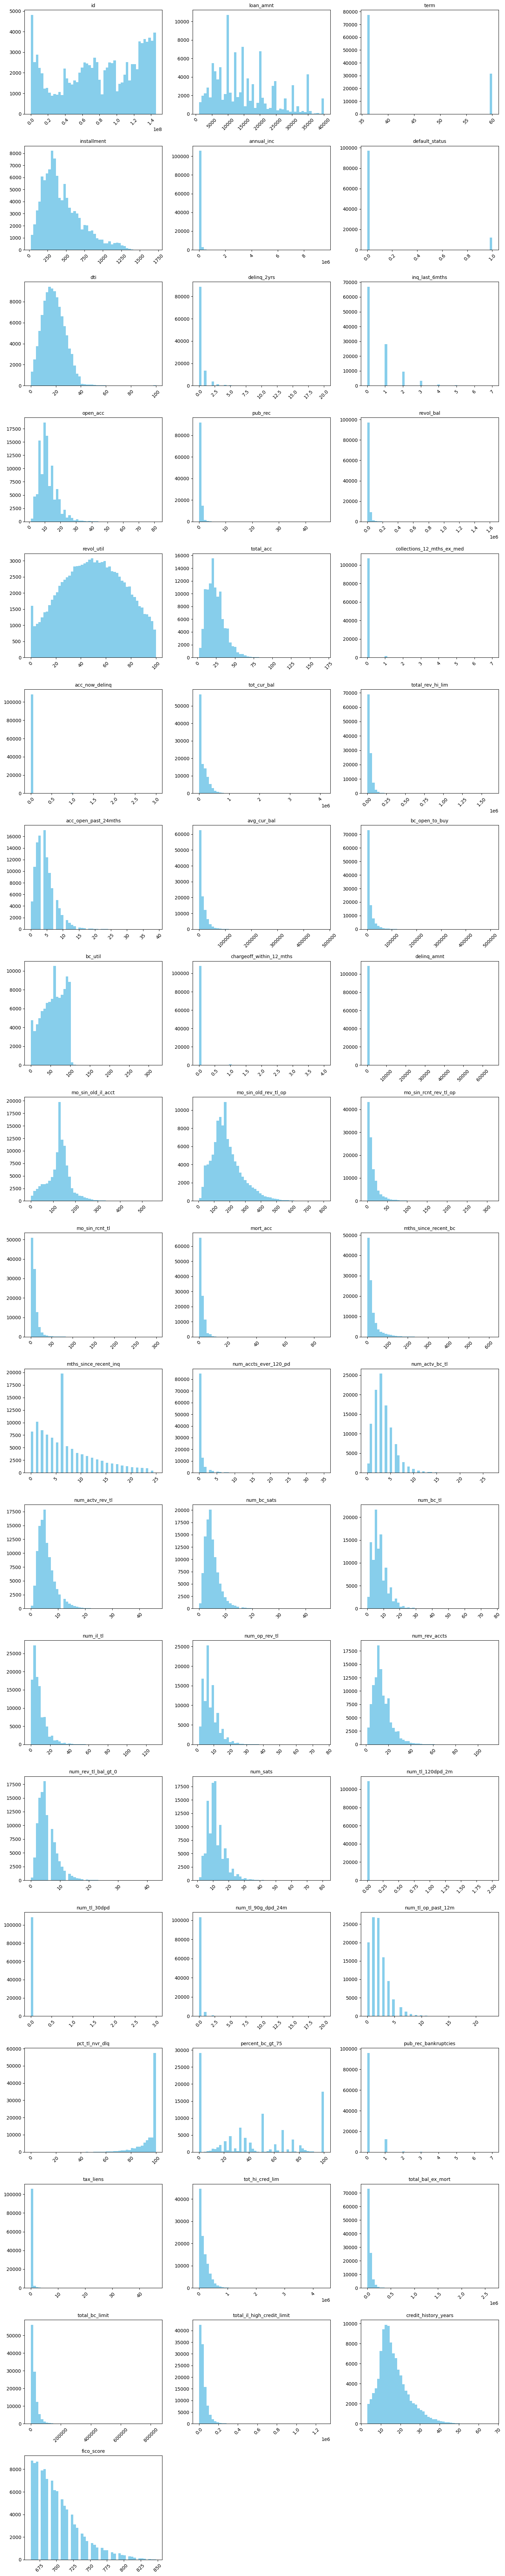

In [ ]:
display_distributions(df)


Now, let's deal with skewness issues. We will group the following numerical features into the following categories
- **Highly Right Skewed (Pct / Probability)**: Logit Transformation
- **Highly Right Skewed (Continuous Feature)**: Log Transformation, Else Box-Cox 
- **Discrete Variables**: WoE binning in Feature Selection 


⚠️ At this checkpoint, I chanced upon how the usage of WoE binning and Feature Selection was robust to outliers and skewness. For example, outliers can be binned into a separate category of itself in WoE binning. Upon this, the WoE encoding of continuous column replaces the original continuous column with each row's bin's WoE value (log-odds scale). Since we are not feeding raw scales of continuous values into our future model, there will not be skewness fixing or transformations needed. 

Since we still made some minor changes, i.e. removing placeholders and illogical values of some of our features, let's log it to `wandb` to simulate the adherence to strict Basel regulations. 

In [ ]:
run_model_checkpoint(df=df, name='log_reg_outlier_handling', date_cutoff='2017-08-01', sample_proportion=0.05, model_type='logistic_regression_v1.3')

Accuracy,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.70631
F1 Score,0.80392
Gini,0.38853
Model Type,logistic_regression_...
Precision,0.95624
Recall,0.70631


# 2. Multicollinearity Handling 

Now let's handle multicollinearity. Multicollinearity occurs when two or more features in a dataset are highly correlated with each other. This can lead to:

- 🚫 **Unstable model coefficients**
- 📉 **Reduced model interpretability**
- ⚠️ **Overfitting and inflated variance**

In credit risk modeling, we handle multicollinearity to ensure model robustness and regulatory compliance. From there, we shall compute the VIF (Variance Inflation Factor), which tells us how much 'extra noise' is added to the estimate of a variable, due to how it overlaps with other variables. Since there is no in-built library to calculate VIF in PySpark, we shall sample part of the data and use the following formula to compute each variable's VIF. 

$$
\text{VIF}(X_i) = \frac{1}{1 - R_i^2}
$$


   - VIF < 5 → Acceptable
   - 5 ≤ VIF < 10 → Moderate concern
   - VIF ≥ 10 → Consider removing or combining feature

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark import StorageLevel

def calculate_vif(df, features, threshold=5.0, sample_frac=0.05, seed=42):
    """
    For each feature of the df, calculate the Variance Inflation Factor (VIF) to check for multicollinearity.
    """
    work_df = (
        df.select(features)                 # keep only numeric columns
          .sample(fraction=sample_frac, seed=seed)
          .persist(StorageLevel.MEMORY_AND_DISK) # store the sampled in ram, spill to disk if needed (impt since i need to assemble vectors of other features, for each given feature) -> constant ref to this df
    )
    _ = work_df.count()  # materialize cache
    
    vif_scores = []
    
    # --- 2)  Loop through features to compute VIF -------------
    for idx, feature in enumerate(features, start=1):
        other = [c for c in features if c != feature]
        
        # Assemble other features into a single vector
        assembler = VectorAssembler(
            inputCols=other,
            outputCol="features_vec"
        )
        temp = assembler.transform(work_df).select("features_vec", feature)
        
        # Regress feature ~ other features  → get R²
        lr = LinearRegression(featuresCol="features_vec", labelCol=feature, regParam=0.001)
        r2 = lr.fit(temp).summary.r2
        
        vif = float("inf") if r2 >= 1 else 1.0 / (1.0 - r2)
        vif_scores.append((feature, vif))
    
    
    # --- 3)  Split keep vs. drop ------------------------------
    keep_cols = [(f, v) for f, v in vif_scores if v <= threshold]
    drop_cols = [(f, v) for f, v in vif_scores if v >  threshold]
    
    return (keep_cols, drop_cols)
 

In [ ]:
excluded_cols = ['id', 'issue_d', 'default_status', 'class_weight_col', 'earliest_cr_line']  # Exclude non-numeric and target columns
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType) and field.name not in excluded_cols]


to_keep, to_drop = calculate_vif(df, numeric_columns, threshold=5.0, sample_frac=0.05)

print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in to_keep:
    print(f" - {feature}: {vif}")
    
print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in to_drop:
    print(f" - {feature}: {vif}")

25/07/20 22:33:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


✅ Features to Keep (VIF <= 5.0):
 - term: 3.4888268655381576
 - annual_inc: 1.2937211863906362
 - dti: 1.459723487608306
 - delinq_2yrs: 2.236958263021533
 - inq_last_6mths: 1.4995613744423988
 - revol_util: 4.919374699003767
 - collections_12_mths_ex_med: 1.0332459197788555
 - acc_now_delinq: 4.963120231455083
 - acc_open_past_24mths: 3.092783283805134
 - chargeoff_within_12_mths: 1.059046262605324
 - delinq_amnt: 1.0962120776210007
 - mo_sin_old_il_acct: 1.4591517723287368
 - mo_sin_rcnt_rev_tl_op: 2.288740539900248
 - mo_sin_rcnt_tl: 1.8561831581820922
 - mort_acc: 2.8231618782708288
 - mths_since_recent_bc: 1.7327673522957194
 - mths_since_recent_inq: 1.4166628712094915
 - num_accts_ever_120_pd: 1.7947213592022317
 - num_tl_120dpd_2m: 1.726879928786857
 - num_tl_30dpd: 4.27666690776197
 - num_tl_90g_dpd_24m: 1.9727426243843327
 - num_tl_op_past_12m: 2.7365872535738647
 - pct_tl_nvr_dlq: 2.155072644746302
 - percent_bc_gt_75: 3.590773787613567
 - pub_rec_bankruptcies: 4.948047140007

Now that we have identified the variables that have high VIF, we know that this means something. If I keep these variables in the model, it will inflate the other features' coefficients by too much, leading to an unstable model. However, we should not blindly drop these variables, we have to note that these variables inflate VIF of other variables as well. As such, we should execute the plan below to deal with multicolllinearity. 

1) Find out which variables are highly correlated with each other (Correlation Matrix)
2) In similar variables (highly multicollinear), rank variables (decide which to drop) based on business explanability / statistical significance of IV (Information Value) score / VIF
3) Drop less important variables

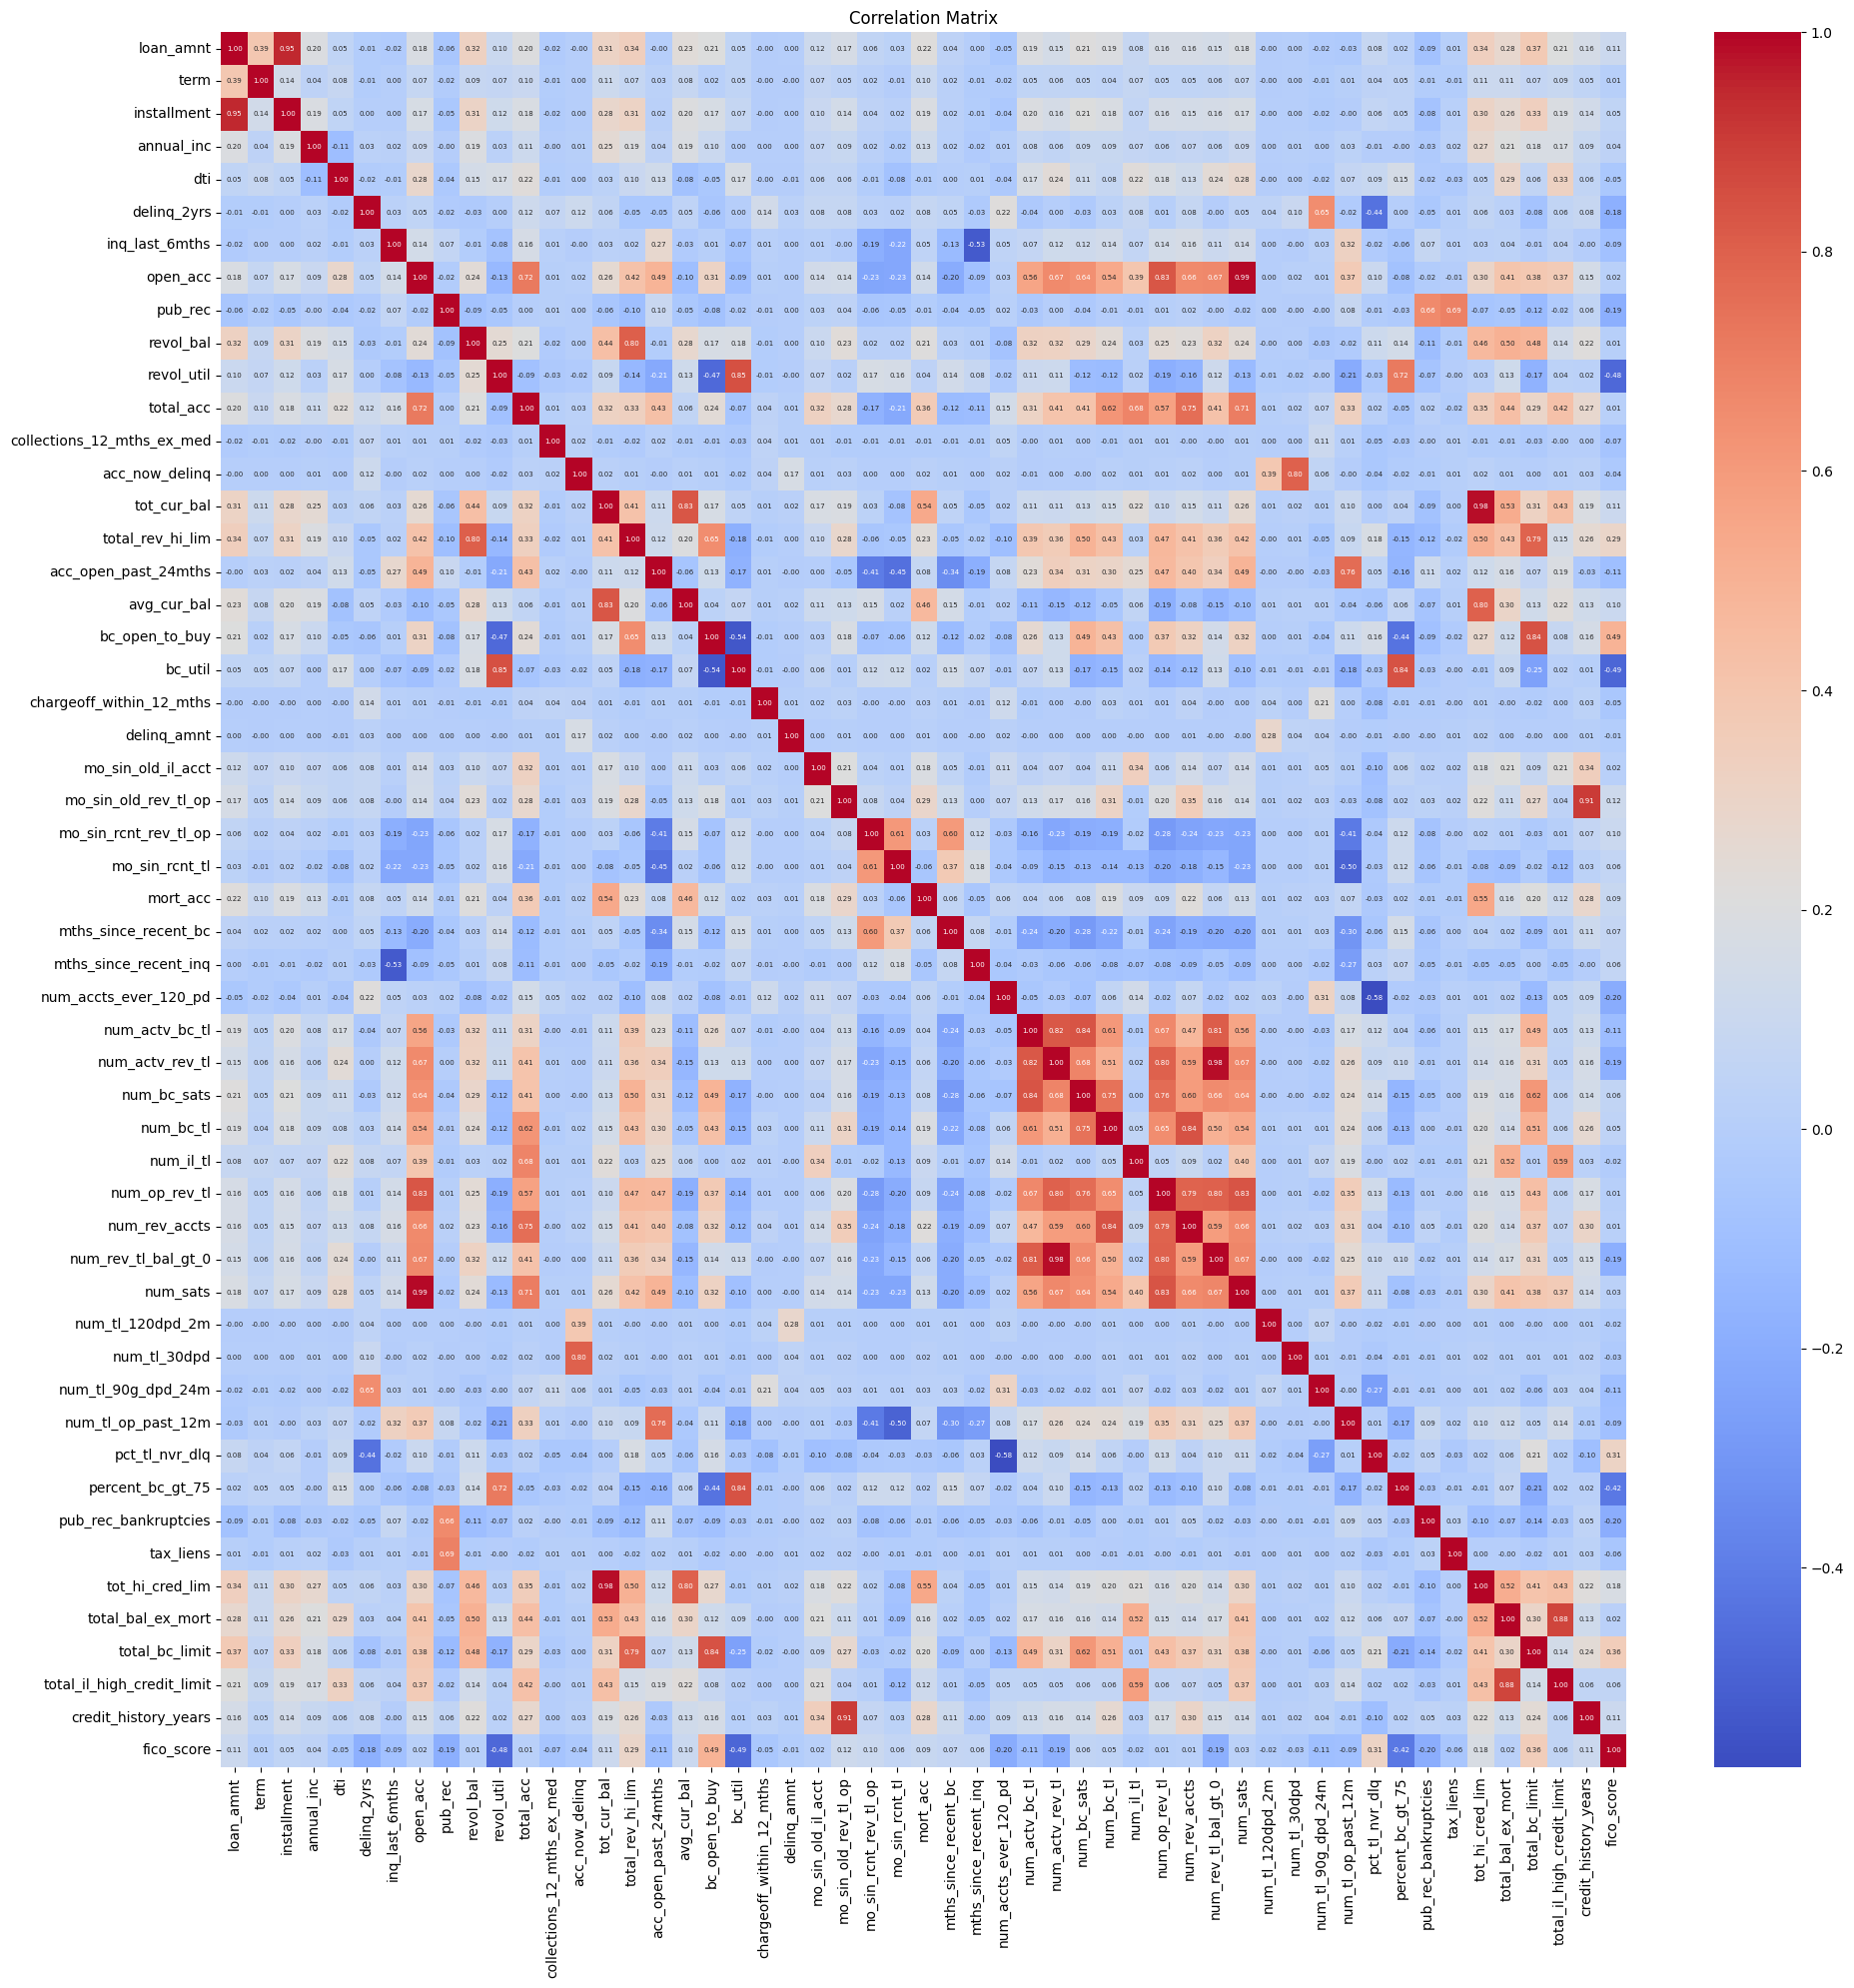

❗ High Correlation Pairs (|ρ| > 0.7):
loan_amnt vs installment: correlation = 0.95
open_acc vs total_acc: correlation = 0.72
open_acc vs num_op_rev_tl: correlation = 0.83
open_acc vs num_sats: correlation = 0.99
revol_bal vs total_rev_hi_lim: correlation = 0.80
revol_util vs bc_util: correlation = 0.85
revol_util vs percent_bc_gt_75: correlation = 0.72
total_acc vs num_rev_accts: correlation = 0.75
total_acc vs num_sats: correlation = 0.71
acc_now_delinq vs num_tl_30dpd: correlation = 0.80
tot_cur_bal vs avg_cur_bal: correlation = 0.83
tot_cur_bal vs tot_hi_cred_lim: correlation = 0.98
total_rev_hi_lim vs total_bc_limit: correlation = 0.79
acc_open_past_24mths vs num_tl_op_past_12m: correlation = 0.76
avg_cur_bal vs tot_hi_cred_lim: correlation = 0.80
bc_open_to_buy vs total_bc_limit: correlation = 0.84
bc_util vs percent_bc_gt_75: correlation = 0.84
mo_sin_old_rev_tl_op vs credit_history_years: correlation = 0.91
num_actv_bc_tl vs num_actv_rev_tl: correlation = 0.82
num_actv_bc_tl vs 

DataFrame[features: vector]

In [ ]:
# Step 1: Correlation Matrix Calculation
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vect = assembler.transform(df).select("features").cache()
df_vect.count()  # force materialization of df_vect (required materialised cache since subseuqent operations will use this df)

corr_matrix = Correlation.corr(df_vect, "features", method="pearson").head()[0]
corr_array = corr_matrix.toArray()

# Display in Seaborn (Requires pandas df)
corr_df = pd.DataFrame(corr_array, index=numeric_columns, columns=numeric_columns)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", 
            annot_kws={"size": 5})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Extract high-correlation pairs (|ρ| > 0.7)
print("❗ High Correlation Pairs (|ρ| > 0.7):")
threshold = 0.7
high_corr_pairs = [
    (numeric_columns[i], numeric_columns[j], corr_array[i, j])
    for i in range(len(numeric_columns))
    for j in range(i + 1, len(numeric_columns))
    if abs(corr_array[i, j]) > threshold
]

# Display top correlations
for var1, var2, corr_val in high_corr_pairs:
    print(f"{var1} vs {var2}: correlation = {corr_val:.2f}")
    
df_vect.unpersist()


From the correlation matrix, we have identified some high correlation pairs with | Pearson Coefficient | > 0.7. Let's group highly correlated variables together. We shall understand why they may be highly correlated along the way, and drop the less important feature as a result. **Less important** can be based on IV calculation, business intuition or explanability. 

| #  | Cluster (ρ ≥ 0.70)                                                                                                 | **Keep (this)**            | Drop (these)                                                                                       | Key justification & reason for correlation                                                                                                                                                                                              |
| -- | ------------------------------------------------------------------------------------------------------------------ | -------------------------- | -------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 1  | `loan_amnt` ↔ `installment` (0.95)                                                                                 | **`loan_amnt`**            | `installment`                                                                                      | Raw loan amount is intuitive; `installment` is a derived feature of amount × interest rate × term                                                              |
| 2  | Account counts: `open_acc`, `total_acc`, `num_op_rev_tl`, `num_sats` , `num_rev_accts`                          | **`open_acc`**   , `num_sats` -> create interaction feature to reduce multicollinearity and measure proportion of accounts which are satisfactory          | `total_acc`, `num_op_rev_tl`, `num_rev_accts`                            | “Open accounts”, though has > VIF than `total_acc`, but reflects borrower's recent credit behaviour. The rest just have high VIF values, and ought to be dropped.   |
| 3  | Revolving limits/balances: `revol_bal` ↔ `total_rev_hi_lim`                                 | **`total_rev_hi_lim`**            | `revol_bal`,                                                                | Both has similar VIF, `total_rev_hi_lim` can measure credit capacity a borrower has. `revol_bal` does is already utilised in calculation of `revol_val`;                                                                        |
| 4  | Utilisation trio: `revol_util`, `bc_util`, `percent_bc_gt_75`                                                      | **`revol_util`**           | `bc_util`, `percent_bc_gt_75`                                                                      | Overall revolving‑utilisation is industry standard, regulator‑friendly, and usually leads IV. `bc_util` is just a part of `revol_util` and many borrowers will hit the 75% threshold when utilisation is high                                                             |
| 5  | Delinquency snapshot: `acc_now_delinq` ↔ `num_tl_30dpd`                                                            | **`acc_now_delinq`**       | `num_tl_30dpd`                                                                                     | “Accounts now delinquent” is cleaner (represents borrower's financial capability at point of loan origination). Both have similar VIF, and `num_tl_30dpd` represents number of tradelines / accounts with 30+ days past payment date, which overlaps strongly with features like `num_tl_120dpd`.  Delinquencies which may have been cleared can be in `num_tl_30dpd` as well.                                                   |
| 6  | Current balances vs limits: `tot_cur_bal`, `avg_cur_bal`, `tot_hi_cred_lim`                                        | **`tot_hi_cred_lim`**          | `avg_cur_bal`, `tot_cur_bal`                                                                   | `avg_cur_bal` & other features in this cluster and `tot_hi_cred_lim` is highly correlated. We decided to leave `tot_hi_cred_lim` in Cluster 3 to assess if sum of all credit limits across trade lines has an impact on probability of a defaulted loan.                                                                          |
| 7  | Bank‑card limit vs availability: `bc_open_to_buy` ↔ `total_bc_limit`                                               | **`bc_open_to_buy`**       | `total_bc_limit`                                                                                   | Both have similar VIF values. `total_bc_limit` is a subset in `tot_hi_cred_lim` feature earlier, since `total_bc_limit` is only the credit limit across bank cards, e.g. credit cards, but `tot_hi_cred_lim` refers to this, and credit limits of mortgages, installment accounts etc.   `bc_open_to_buy` can help us assess if a borrower's credit capacity can have impact on default probability.                                                                                                 |
| 8  | Credit‑history length: `mo_sin_old_rev_tl_op` ↔ `credit_history_years`                                             | **`credit_history_years`** | `mo_sin_old_rev_tl_op`                                                                             | Both are metrics of a borrower's credit history. `mo_sin_old_rev_tl_op` is more granular (only refers to revolving trade lines, excluding mortgages and installments etc). Entire credit history is a better measure, especially when both have similar VIF.                                                                                                 |
| 9  | Active revolving lines: `num_actv_bc_tl`, `num_actv_rev_tl`, `num_rev_tl_bal_gt_0`, `num_bc_sats`, `num_op_rev_tl` | **`num_actv_bc_tl`, `num_bc_sats`** -> Interaction feature to calculate proportion of satisfactory bank cards (removes multicollinearity between these 2 features)       | `num_actv_rev_tl`, `num_rev_tl_bal_gt_0`, `num_op_rev_tl` (already dropped in Cl 2) |  `num_rev_tl_bal_gt_0` has high VIF, `num_actv_rev_tl` only represents number of active accounts, without taking into account the proportion of good credit performance, which is crucial in estimating default probability                                                                                                     |
| 10 | Tradeline breadth: `num_bc_tl` ↔ `num_rev_accts`                                                                   | **`num_bc_tl`**            | `num_rev_accts`                                                                                    | Credit Cards are more specific, and provide insight to whether number of bank cards issued affects consumer credit risk the most, compared to revolving accounts (which can include HELOC -> using part of one's house as collateral); “all revolving accts” is broader but collinear and weaker in IV tests.                                                                                                  |
| 11 | Installment‑loan exposure: `total_bal_ex_mort` ↔ `total_il_high_credit_limit`                                      | **`total_bal_ex_mort`**    | `total_il_high_credit_limit`                                                                       | Balance‑excluding‑mortgage is a direct leverage measure of borrower's current financial situation; high‑credit limit is more policy‑driven, than representative of a borrower's financial situation                                                                                            |


Now, after dropping the relevant variables and creating the interaction features, let's examine if there are still multicollinearity between our features.

In [ ]:
to_drop_cols = [
    "installment", 
    "total_acc", "num_op_rev_tl", "num_rev_accts", 
    "revol_bal", 
    "bc_util", "percent_bc_gt_75",
    "num_tl_30dpd", 
    "avg_cur_bal", "tot_cur_bal", 
    "total_bc_limit", 
    "mo_sin_old_rev_tl_op",
    "num_actv_rev_tl", "num_rev_tl_bal_gt_0", "num_op_rev_tl",
    "num_rev_accts", 
    "total_il_high_credit_limit",
]

df = df.drop(*to_drop_cols)

df = df.withColumn('proportion_satisfac_accounts', col('num_sats')/(col('open_acc') + lit(1) )) # prevent division by 0 
df = df.withColumn('proportion_satisfac_bc_tl', col('num_bc_sats')/(col('num_actv_bc_tl') + lit(1)))

new_numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType) and field.name not in excluded_cols]

to_keep1, to_drop1 = calculate_vif(df, new_numeric_columns, threshold=5.0, sample_frac=0.05)

print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in to_keep1:
    print(f" - {feature}: {vif}")
    
print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in to_drop1:
    print(f" - {feature}: {vif}")


✅ Features to Keep (VIF <= 5.0):
 - loan_amnt: 1.4838107645317313
 - term: 1.203822544931172
 - annual_inc: 1.2597605485339933
 - dti: 1.3058044380431724
 - delinq_2yrs: 2.198158548598535
 - inq_last_6mths: 1.481066645661674
 - revol_util: 2.1353108864763515
 - collections_12_mths_ex_med: 1.031287705584974
 - acc_now_delinq: 1.1869032513464288
 - total_rev_hi_lim: 3.0142037558010615
 - acc_open_past_24mths: 2.9927781988919713
 - bc_open_to_buy: 2.9928739759496077
 - chargeoff_within_12_mths: 1.0562702666646604
 - delinq_amnt: 1.1123619486702645
 - mo_sin_old_il_acct: 1.3270438213998685
 - mo_sin_rcnt_rev_tl_op: 2.2390177545556993
 - mo_sin_rcnt_tl: 1.859408059654659
 - mort_acc: 1.5886503575662072
 - mths_since_recent_bc: 1.7019466830070344
 - mths_since_recent_inq: 1.4168501658363626
 - num_accts_ever_120_pd: 1.7755456723701109
 - num_bc_tl: 2.6012336024633864
 - num_il_tl: 2.0003655056486735
 - num_tl_120dpd_2m: 1.2610515512654727
 - num_tl_90g_dpd_24m: 1.942911686416379
 - num_tl_op

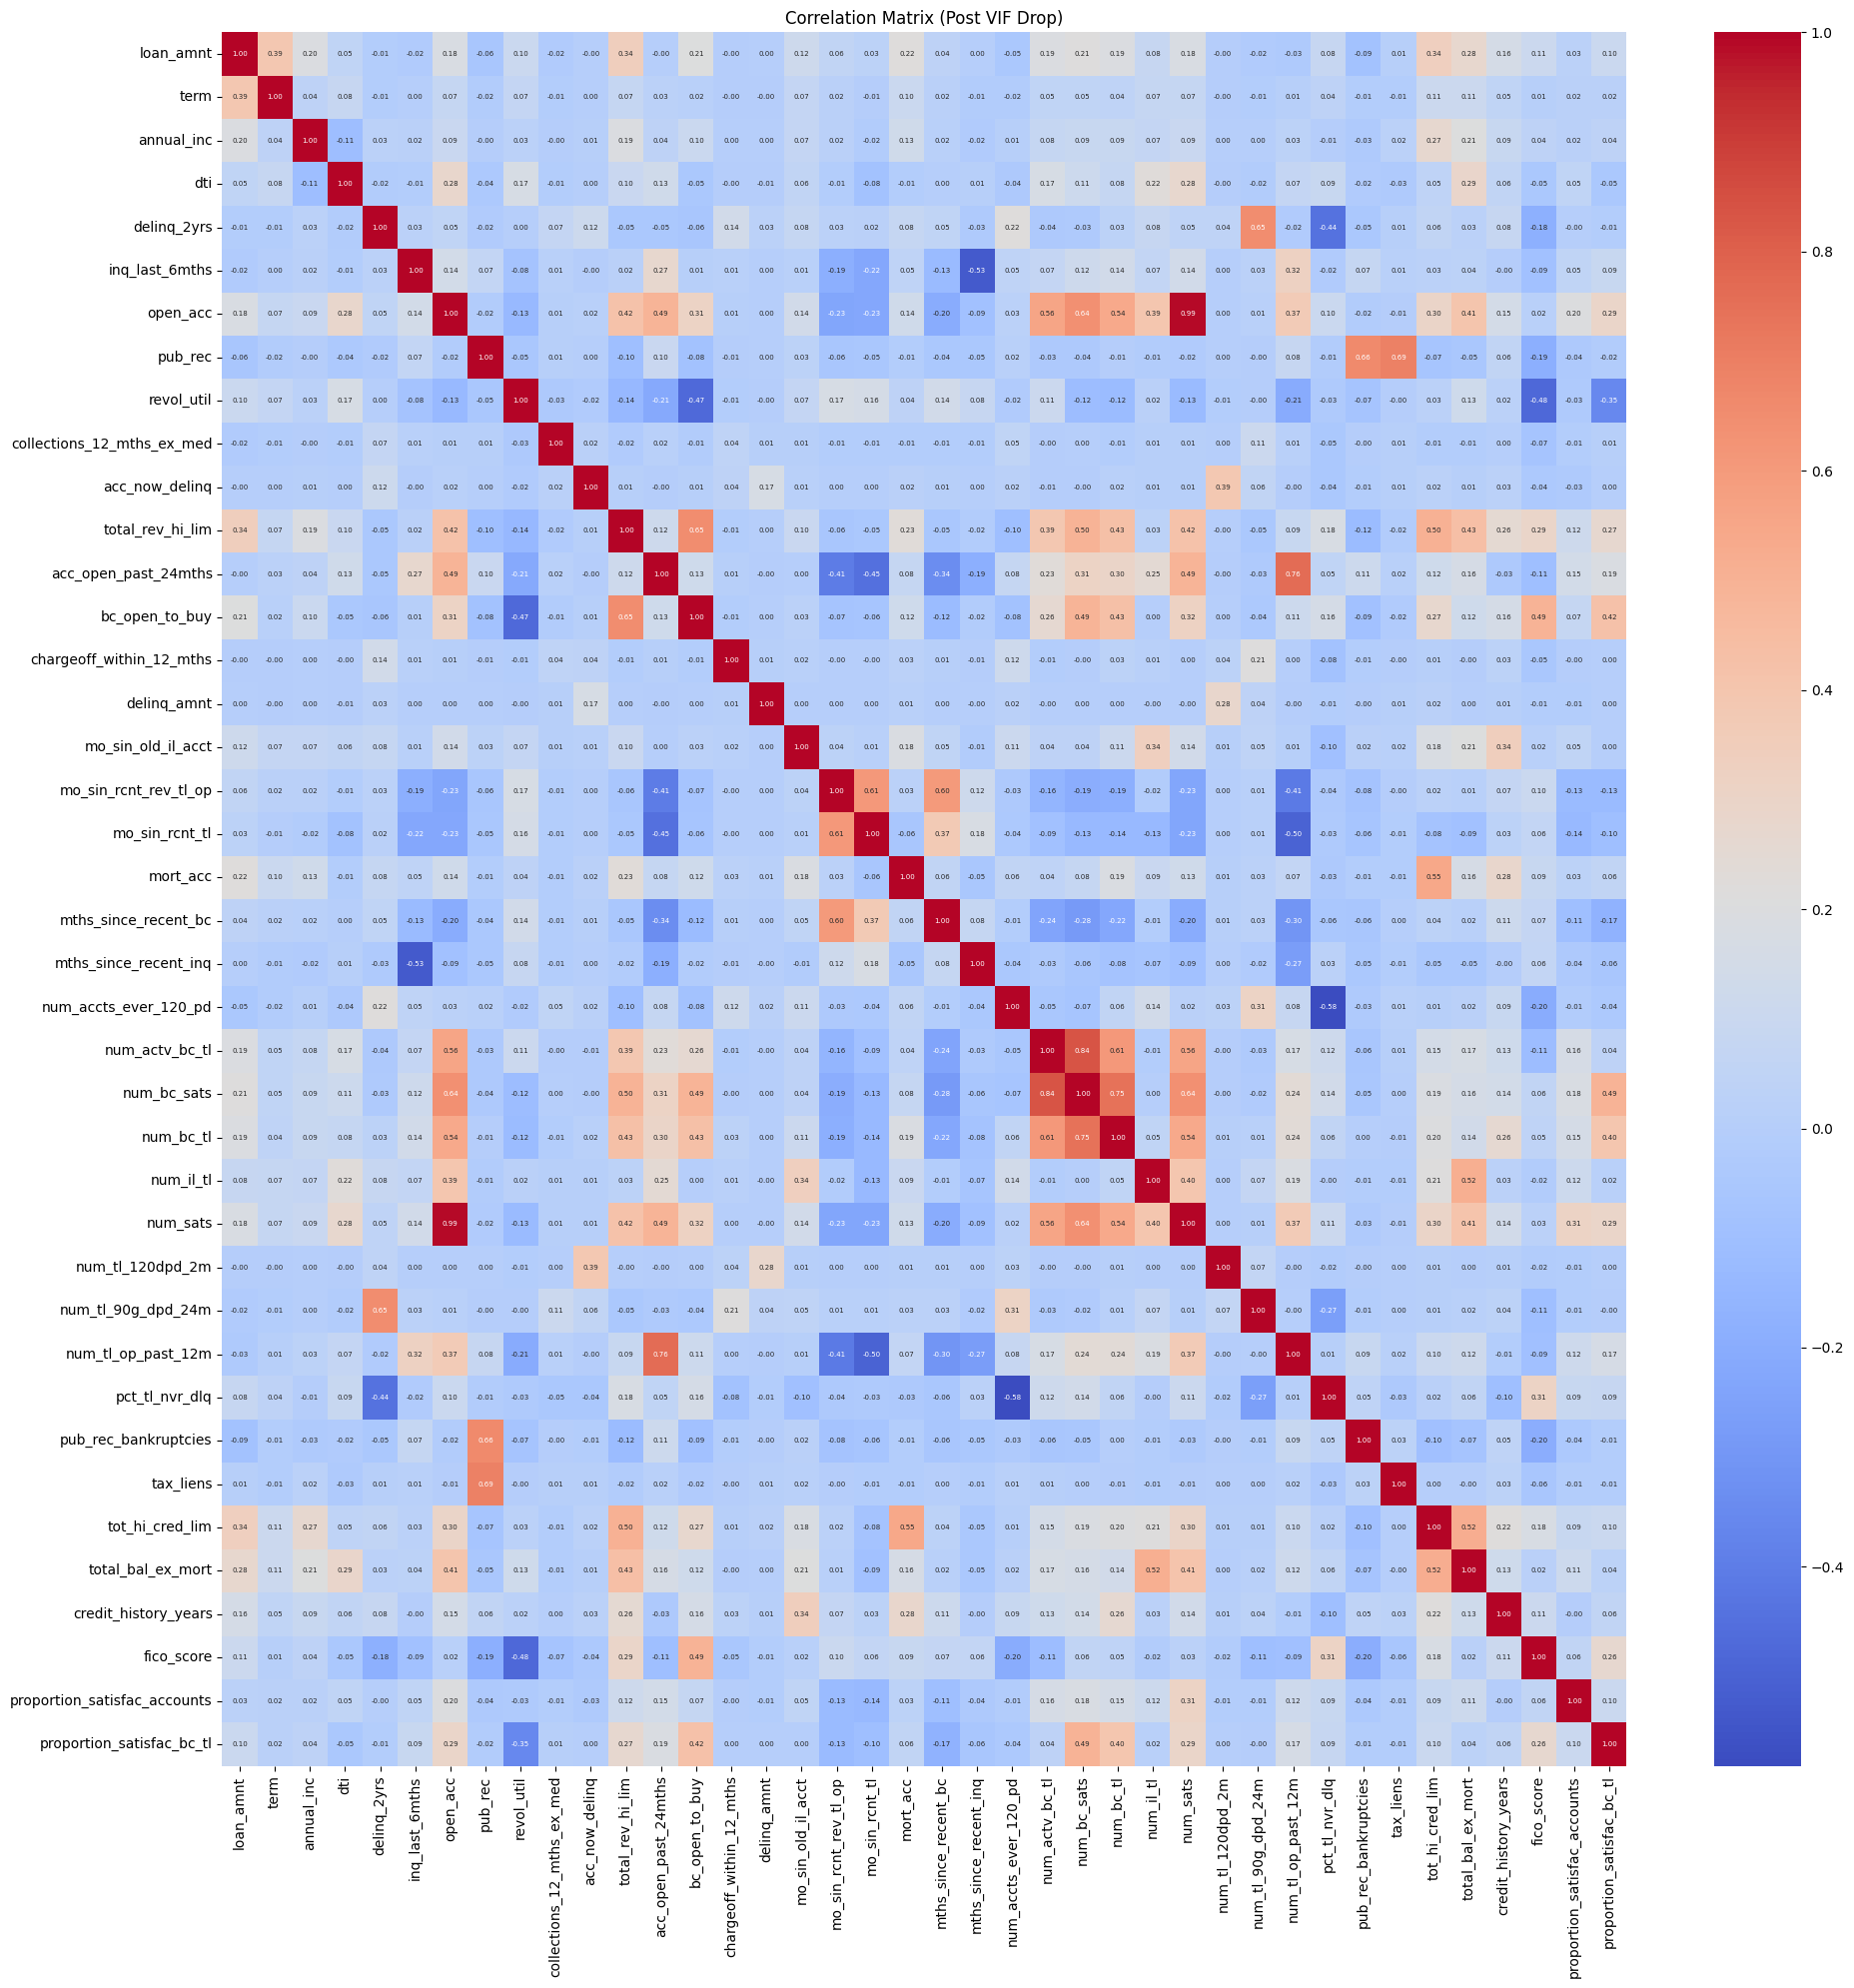

❗ High Correlation Pairs (|ρ| > 0.7):
open_acc vs num_sats: correlation = 0.99
acc_open_past_24mths vs num_tl_op_past_12m: correlation = 0.76
num_actv_bc_tl vs num_bc_sats: correlation = 0.84
num_bc_sats vs num_bc_tl: correlation = 0.75


DataFrame[features: vector]

In [ ]:

assembler1 = VectorAssembler(inputCols=new_numeric_columns, outputCol="features")
df_vect1 = assembler1.transform(df).select("features").cache()
df_vect1.count()  # force materialization of df_vect1 (required materialised cache since subseuqent operations will use this df)

corr_matrix1 = Correlation.corr(df_vect1, "features", method="pearson").head()[0]
corr_array1 = corr_matrix1.toArray()

# Display in Seaborn (Requires pandas df)
corr_df1 = pd.DataFrame(corr_array1, index=new_numeric_columns, columns=new_numeric_columns)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df1, annot=True, cmap="coolwarm", fmt=".2f", 
            annot_kws={"size": 5})
plt.title("Correlation Matrix (Post VIF Drop)")
plt.tight_layout()
plt.show()

# Extract high-correlation pairs (|ρ| > 0.7)
print("❗ High Correlation Pairs (|ρ| > 0.7):")
threshold = 0.7
high_corr_pairs1 = [
    (new_numeric_columns[i], new_numeric_columns[j], corr_array1[i, j])
    for i in range(len(new_numeric_columns))
    for j in range(i + 1, len(new_numeric_columns))
    if abs(corr_array1[i, j]) > threshold
]

# Display top correlations
for var1, var2, corr_val in high_corr_pairs1:
    print(f"{var1} vs {var2}: correlation = {corr_val:.2f}")
    
df_vect1.unpersist()

In [ ]:
# Drop columns of interaction features 

df = df.withColumn('proportion_satisfac_accounts', col('num_sats')/(col('open_acc') + lit(1) )) # prevent division by 0 
df = df.withColumn('proportion_satisfac_bc_tl', col('num_bc_sats')/(col('num_actv_bc_tl') + lit(1)))

remove_features = ['num_sats', 'open_acc', 'num_bc_sats', 'num_actv_bc_tl']
df1 = df.drop(*remove_features) # save to new df1, so we don't lose the original df

In [ ]:
new_numeric_columns_df1 = [field.name for field in df1.schema.fields if isinstance(field.dataType, NumericType) and field.name not in excluded_cols]

to_keep_df1, to_drop_df1 = calculate_vif(df1, new_numeric_columns_df1, threshold=5.0, sample_frac=0.05)

print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in to_keep_df1:
    print(f" - {feature}: {vif}")
    
print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in to_drop_df1:
    print(f" - {feature}: {vif}")

✅ Features to Keep (VIF <= 5.0):
 - loan_amnt: 1.4792458320797475
 - term: 1.2036650895012848
 - annual_inc: 1.2585827965496301
 - dti: 1.2575529018567602
 - delinq_2yrs: 2.1784458237398487
 - inq_last_6mths: 1.4787124011771708
 - revol_util: 2.0784703068465418
 - collections_12_mths_ex_med: 1.0308943240514934
 - acc_now_delinq: 1.1852969735927847
 - total_rev_hi_lim: 2.920152571867592
 - acc_open_past_24mths: 2.8324913319166005
 - bc_open_to_buy: 2.8476764651317406
 - chargeoff_within_12_mths: 1.0557963933397925
 - delinq_amnt: 1.1119575314462387
 - mo_sin_old_il_acct: 1.3256092984057943
 - mo_sin_rcnt_rev_tl_op: 2.220743814590786
 - mo_sin_rcnt_tl: 1.8494277817043818
 - mort_acc: 1.5693450681572287
 - mths_since_recent_bc: 1.6590071810960207
 - mths_since_recent_inq: 1.4163884147717554
 - num_accts_ever_120_pd: 1.761784802650917
 - num_bc_tl: 1.726568136270006
 - num_il_tl: 1.7713131942693097
 - num_tl_120dpd_2m: 1.2609998707154506
 - num_tl_90g_dpd_24m: 1.9372285957491733
 - num_tl_

From the results above, the situation has improved a lot thus far and we have only 3 features left which has a high VIF. To recap, it means that including such variables will mess up coefficients of other variables if we include them in the model. 

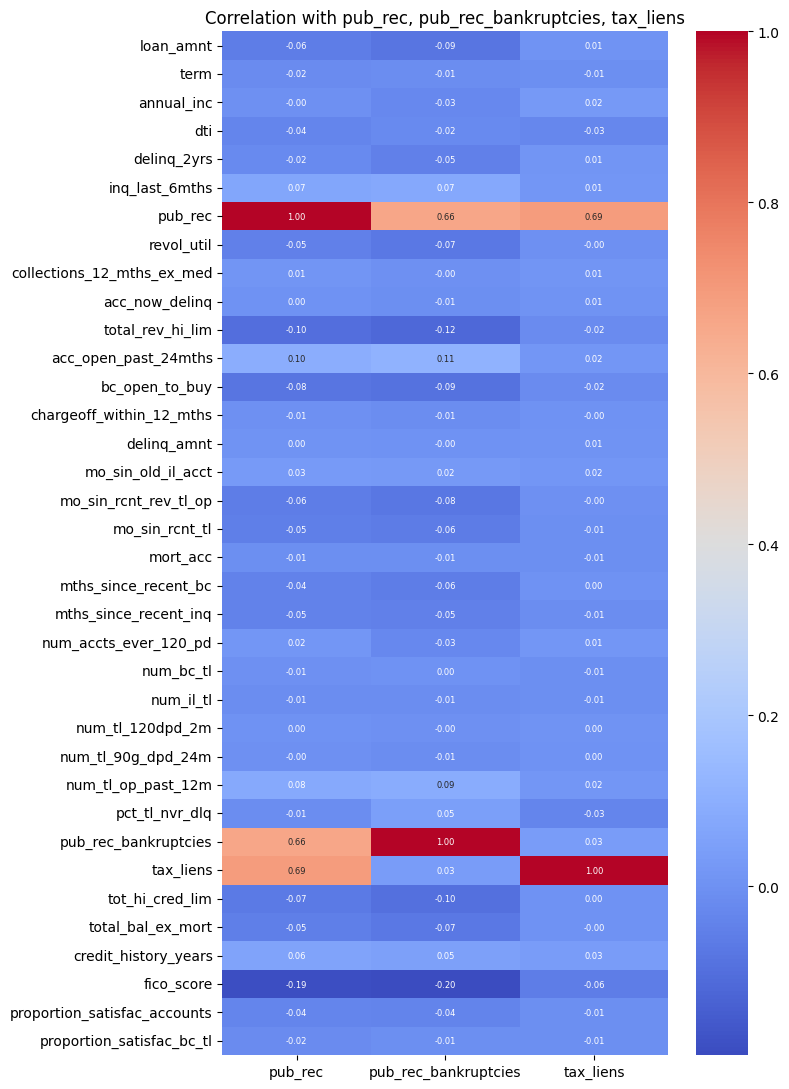

❗ High Correlation Pairs (|ρ| > 0.7):
acc_open_past_24mths vs num_tl_op_past_12m: correlation = 0.76


DataFrame[features: vector]

In [ ]:

assembler2 = VectorAssembler(inputCols=new_numeric_columns_df1, outputCol="features")
df_vect2 = assembler2.transform(df1).select("features").cache()
df_vect2.count()  # force materialization of df_vect2 (required materialised cache since subseuqent operations will use this df1)

corr_matrix2 = Correlation.corr(df_vect2, "features", method="pearson").head()[0]
corr_array2 = corr_matrix2.toArray()

# Display in Seaborn (Requires pandas df1)
corr_df2 = pd.DataFrame(corr_array2, index=new_numeric_columns_df1, columns=new_numeric_columns_df1)

# ✅ Subset: only show corr of pub_rec + bankruptcies + tax_liens with all others
target_vars = ['pub_rec', 'pub_rec_bankruptcies', 'tax_liens']
target_vars = [v for v in target_vars if v in corr_df2.columns]  # safety check

if target_vars:
    corr_subset = corr_df2[target_vars]  # all rows, selected columns
    plt.figure(figsize=(8, len(corr_subset) * 0.25 + 2))
    sns.heatmap(corr_subset, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 6})
    plt.title("Correlation with pub_rec, pub_rec_bankruptcies, tax_liens")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Target columns not found in correlation matrix.")
    
    
# Extract high-correlation pairs (|ρ| > 0.7)
print("❗ High Correlation Pairs (|ρ| > 0.7):")
threshold = 0.7
high_corr_pairs2 = [
    (new_numeric_columns_df1[i], new_numeric_columns_df1[j], corr_array2[i, j])
    for i in range(len(new_numeric_columns_df1))
    for j in range(i + 1, len(new_numeric_columns_df1))
    if abs(corr_array2[i, j]) > threshold
]

# Display top correlations
for var1, var2, corr_val in high_corr_pairs2:
    print(f"{var1} vs {var2}: correlation = {corr_val:.2f}")
    
df_vect2.unpersist()

From the results above, we now comprehend the reason behind the high VIF for `pub_rec`. It exhibits moderate correlation with `pub_rec_bankruptcies` and `tax_liens`. Given that tax liens and bankruptcies are all public records and impact credit scores, it is reasonable to exclude both of them from the model. For our specific use case, we require only predicting the probability of default with interpretability. In credit risk modeling, any type of public record is already a significant risk factor. Bankruptcies and tax liens are not commonly encountered, hence it is generally preferable to model with a broader feature such as `pub_rec`, which encompasses the presence of any public record. This approach provides the model with a more stable and interpretable signal to increase default risk significantly.

In [ ]:
public_records_granular_cols = ['tax_liens', 'pub_rec_bankruptcies']
df2 = df1.drop(*public_records_granular_cols)

In [ ]:
# Examine Multicollinearity Again
new_numeric_columns_df2 = [field.name for field in df2.schema.fields if isinstance(field.dataType, NumericType) and field.name not in excluded_cols]


to_keep_df2, to_drop_df2 = calculate_vif(df2, new_numeric_columns_df2, threshold=5.0, sample_frac=0.05)

print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in to_keep_df2:
    print(f" - {feature}: {vif}")
    
print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in to_drop_df2:
    print(f" - {feature}: {vif}")

✅ Features to Keep (VIF <= 5.0):
 - loan_amnt: 1.4780485225617
 - term: 1.203409447043461
 - annual_inc: 1.2582462268112928
 - dti: 1.2573342847238258
 - delinq_2yrs: 2.173650610625373
 - inq_last_6mths: 1.4784376280217935
 - pub_rec: 1.114752167858003
 - revol_util: 2.0488966807797975
 - collections_12_mths_ex_med: 1.0299205059745322
 - acc_now_delinq: 1.1850965861911948
 - total_rev_hi_lim: 2.916542882814776
 - acc_open_past_24mths: 2.8315651838533418
 - bc_open_to_buy: 2.8474248257199113
 - chargeoff_within_12_mths: 1.0556075636638331
 - delinq_amnt: 1.1119527776447657
 - mo_sin_old_il_acct: 1.325248725032673
 - mo_sin_rcnt_rev_tl_op: 2.2207065118539004
 - mo_sin_rcnt_tl: 1.8494035832736497
 - mort_acc: 1.566728565678899
 - mths_since_recent_bc: 1.6589438768319504
 - mths_since_recent_inq: 1.4163507136741496
 - num_accts_ever_120_pd: 1.7574222911423323
 - num_bc_tl: 1.72635414516118
 - num_il_tl: 1.7712026653036437
 - num_tl_120dpd_2m: 1.2609835866496701
 - num_tl_90g_dpd_24m: 1.934

In [ ]:
# Now that all our features are VIF < 5.0, we can assess our model performance  
run_model_checkpoint(df=df2, name='log_reg_handled_multicollinearity', date_cutoff='2017-08-01', sample_proportion=0.05, model_type='logistic_regression_v1.4')

Accuracy,▁
F1 Score,▁
Gini,▁
Precision,▁
Recall,▁
Accuracy,0.69971
F1 Score,0.79948
Gini,0.38294
Model Type,logistic_regression_...
Precision,0.9562
Recall,0.69971


![After multi](../images/multicol.png)
![After multi II](../images/multi%20ii.png)

Let's examine our results above. It seems that outlier handling has taken a small hit on our Gini. However, since the values we removed are highly likely to be placeholders, we should not redo the previous steps, so we maintain data integrity. Also, it may seem that I have done redundant work, i.e. multicollinearity didn't seem to increase our metrics significantly. However, it is important to note that for multicollinearity handling, we are trying to remove duplicated signals, and not give the model more signal. To improve the evalaution metrics, it is important that we make careful decisions in feature engineering and feature selection (subsequent steps). 


In [ ]:
checkpoint2 = df2.limit(5).toPandas()
checkpoint2



,id,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,issue_d,default_status,pymnt_plan,...,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,credit_history_years,fico_score,proportion_satisfac_accounts,proportion_satisfac_bc_tl
0,87023,7500.0,36,E,OWN,22000.0,Not Verified,2007-06-01,0,n,...,0.0,0.0,2.0,100.0,113149.0,37781.0,3.666667,662.0,1.375000,1.0
1,90376,5000.0,36,A,MORTGAGE,200000.0,Not Verified,2007-07-01,0,n,...,0.0,0.0,2.0,100.0,113149.0,37781.0,18.666667,812.0,0.611111,1.0
2,96844,5300.0,36,A,MORTGAGE,74000.0,Not Verified,2007-07-01,0,n,...,0.0,0.0,2.0,100.0,113149.0,37781.0,15.416667,797.0,0.687500,1.0
3,96350,5000.0,36,C,OWN,30000.0,Not Verified,2007-07-01,0,n,...,0.0,0.0,2.0,100.0,113149.0,37781.0,14.250000,702.0,1.000000,1.0
4,107136,12250.0,36,C,RENT,60000.0,Not Verified,2007-07-01,0,n,...,0.0,0.0,2.0,100.0,113149.0,37781.0,38.416667,747.0,1.000000,1.0


# 3. WoE & IV Feature Selection

Before feature selection, it is important I understand certain rules I have to adhere to for WoE. 
1) **Monotonicity**: As `feature` bins/values increase, WoE should increase as well. Just like how Logistic Regression Model fits an S-shaped curve, feature and target class should move in the same direction. Else, it violates linearity assumption of Logistic Regression 

2) **No 0 in Good / Bad Counts (Each Bins)**: Required to compute WoE accurately. Prevents division of 0 in WoE calculation 

3) **Group bins of similar WoE together = Coarse binning**

4) **Min 0.5% of good class & bad class in each bin**: Drop if unimportant / Merge 

Additionally, I shall follow the following rules for selecting my features for PD Modeling (Logistic Regression). Ideally, I should have ~ 20 features, that are at least 0.05. As I run IV scoring through features, their IV scores shall be recorded to `sandbox/feature_iv_trail.xlsx`

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

In [31]:
# --- 1. Define the target directory ---
import os 
from openpyxl import Workbook


output_dir = "../sandbox/"  # e.g. "/home/username/results"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
output_path = os.path.join(output_dir, "feature_iv_trail.xlsx")

# --- 2. Setup Excel workbook ---
wb = Workbook()
ws = wb.active
ws.title = "IV Scores"
ws.append(["feature", "iv", 'type'])

### 2.0 Numerical Features WoE & IV Feature Selection 

As manual WoE binning & ensuring monotonicity of WoE for each variable will be extremely tedious, we will be using `optbinning` Python library to conduct WoE binning. This helps us ensure the ultimate IV score obtained is accurate, and WoE binning adheres to the rules (such as monotonicity, coarse binning etc). 

In [1]:
from optbinning import OptimalBinning
from pyspark.sql.types import IntegerType, DoubleType, FloatType, LongType
import pandas as pd
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# =========================
# Set-up Constants
# =========================

TARGET_COL = "default_status"
SAMPLE_FRAC = 0.05
SEED = 42

IV_THRESHOLDS = {
    "useless": 0.02,
    "weak": 0.1,
    "medium": 0.3,
    "strong": 0.5,
}

# Feature classification containers
iv_categories = {
    "useless": [],
    "weak": [],
    "medium": [],
    "strong": [],
    "suspicious": [],
    "no_variation": [],
}

# =========================
# Helper Functions
# =========================

def get_numerical_cols(df, target_col):
    return [
        f.name for f in df.schema.fields
        if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType))
        and f.name != target_col
    ]

def classify_iv(feature, iv_score):
    for label, threshold in IV_THRESHOLDS.items():
        if iv_score < threshold:
            iv_categories[label].append((feature, iv_score))
            return
    iv_categories["suspicious"].append((feature, iv_score))

def bin_and_classify_feature(feature, x, y, dtype="numerical", interaction="base", ws=None, wb=None, output_path=None):
    optb = OptimalBinning(
        name=feature,
        dtype=dtype,
        monotonic_trend="auto",
        solver="cp"
    )
    optb.fit(x, y)
    binning_table = optb.binning_table

    bin_table = optb.binning_table.build()
    bin_df = pd.DataFrame({
        "Bin": bin_table["Bin"],
        "Count": round(bin_table["Count"], 4),
        "Default Rate (%)": round(bin_table["Event rate"], 4),
        "WOE": bin_table["WoE"],
        "IV": bin_table["IV"]
    })

    bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))
    # 📊 Add plot here:
    
    binning_table.plot(metric="woe", figsize=(8,4)) 
    

    total_iv = bin_df.iloc[-1]["IV"]
    print(f"✅ Total IV for {feature}: {total_iv:.4f}")

    if ws and wb and output_path:
        existing_features = [cell.value for cell in ws["A"] if cell.value]
        if feature not in existing_features:
            ws.append([feature, total_iv, interaction])
            wb.save(output_path)

    classify_iv(feature, total_iv)

# =========================
# Main Execution
# =========================

numerical_cols = get_numerical_cols(df, TARGET_COL)

for feature in numerical_cols:
    if feature == "id":
        continue

    print(f"\n🔍 Feature: {feature}")
    sample_df = (
        df.select(feature, TARGET_COL)
        .sample(fraction=SAMPLE_FRAC, seed=SEED)
        .toPandas()
    )

    if sample_df[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        iv_categories["no_variation"].append(feature)
        continue

    x, y = sample_df[feature], sample_df[TARGET_COL]
    bin_and_classify_feature(feature, x, y, ws=ws, wb=wb, output_path=output_path)



NameError: name 'df' is not defined

In [34]:
for key, val in iv_categories.items():
    print(f"\n{key.capitalize()} Features ({len(val)}):")
    for feature, iv in val:
        print(f" - {feature}: {iv:.4f}")


Useless Features (24):
 - delinq_2yrs: 0.0064
 - open_acc: 0.0183
 - pub_rec: 0.0099
 - collections_12_mths_ex_med: 0.0000
 - acc_now_delinq: 0.0000
 - chargeoff_within_12_mths: 0.0000
 - delinq_amnt: 0.0000
 - mo_sin_old_il_acct: 0.0057
 - mort_acc: 0.0101
 - num_accts_ever_120_pd: 0.0042
 - num_actv_bc_tl: 0.0056
 - num_bc_sats: 0.0007
 - num_bc_tl: 0.0077
 - num_il_tl: 0.0107
 - num_sats: 0.0199
 - num_tl_120dpd_2m: 0.0000
 - num_tl_90g_dpd_24m: 0.0030
 - pct_tl_nvr_dlq: 0.0091
 - pub_rec_bankruptcies: 0.0057
 - tax_liens: 0.0000
 - total_bal_ex_mort: 0.0133
 - credit_history_years: 0.0097
 - proportion_satisfac_accounts: 0.0123
 - proportion_satisfac_bc_tl: 0.0086

Weak Features (15):
 - loan_amnt: 0.0268
 - term: 0.0735
 - annual_inc: 0.0299
 - dti: 0.0585
 - inq_last_6mths: 0.0661
 - revol_util: 0.0459
 - total_rev_hi_lim: 0.0496
 - acc_open_past_24mths: 0.0940
 - bc_open_to_buy: 0.0987
 - mo_sin_rcnt_rev_tl_op: 0.0499
 - mo_sin_rcnt_tl: 0.0591
 - mths_since_recent_bc: 0.0309
 -

In [ ]:

# Inspect features that are savable via feature engineering

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_iv_scores(
#     useless_features,
#     weak_features,
#     medium_features,
#     strong_features,
#     sus_features,
#     iv_threshold=0.02,
#     top_n=None,
#     title="Numerical Features by IV",
#     figsize=(10,6)
# ):
#     """
#     Plot IV scores for selected features grouped by strength level.
    
#     Parameters:
#     - useless_features, weak_features, ..., sus_features: Lists of (feature, IV) tuples
#     - iv_threshold: Minimum IV to show on the plot (default: 0.02)
#     - top_n: Show only top N features by IV (optional)
#     - title: Title of the plot
#     - figsize: Figure size 
#     """
#     all_iv = (
#         useless_features +
#         weak_features +
#         medium_features +
#         strong_features +
#         sus_features
#     )

#     iv_df = pd.DataFrame(all_iv, columns=["Feature", "IV"])
#     iv_df = iv_df[iv_df["IV"] >= iv_threshold].sort_values(by="IV", ascending=False)

#     if top_n:
#         iv_df = iv_df.head(top_n)

#     # Plotting
#     num_bars = len(iv_df)
#     plt.figure(figsize=(figsize[0], max(figsize[1], 0.02 * num_bars)))
#     ax = sns.barplot(data=iv_df, x="IV", y="Feature", palette="Blues_d")

#     for i, (iv, feature) in enumerate(zip(iv_df["IV"], iv_df["Feature"])):
#         ax.text(iv + 0.01, i, f"{iv:.3f}", va='center', fontsize=10, color='black')

#     plt.title(title)
#     plt.xlabel("Information Value (IV)")
#     plt.ylabel("Feature")
#     plt.tight_layout()
#     plt.show()

# plot_iv_scores(useless_features, weak_features, medium_features, strong_features, sus_features, 0.02, 20, figsize=(10,6))

In [ ]:
# def display_numerical_features_iv_category(useless, weak, medium, strong, sus, no_var): 
#     # Numerical Features 
#     print(f"Useless Numerical Features (IV < 0.02): {useless}\n")
#     print(f"Weak Numerical Features (0.02 ≤ IV < 0.1): {weak}\n")
#     print(f"Medium Numerical Features (0.1 ≤ IV < 0.3): {medium}\n")
#     print(f"Strong Numerical Features (0.3 ≤ IV < 0.5): {strong}\n")
#     print(f"Suspicious Numerical Features (IV ≥ 0.5): {sus}\n")
#     print(f"No Variation Features:{no_var}")


# display_numerical_features_iv_category(useless_features, weak_features, medium_features, strong_features, sus_features, no_variation_features)

### 2.1 Categorical Features WoE & IV Feature Selection 

In [ ]:
# from pyspark.sql.types import StringType

# target_col = "default_status"

# # Extract all string-type categorical features
# categorical_cols = [f.name for f in df.schema.fields 
#                     if isinstance(f.dataType, StringType) and f.name != target_col]

# # Binning strength categories
# useless_cat_features = [] 
# weak_cat_features = []
# medium_cat_features = []
# strong_cat_features = [] 
# sus_cat_features = []
# no_var_cat = []

# for feature in categorical_cols:
#     print(f"\n🔍 Feature: {feature}")

#     # Step 1: Sample and convert to pandas
#     sample_df = (
#         df.select(feature, target_col)
#         .sample(fraction=0.05, seed=42)
#         .toPandas()
#     )

#     if sample_df[feature].nunique() < 2:
#         print("⚠️ Not enough variation. Skipping.")
#         no_var_cat.append(feature)
#         continue

#     x = sample_df[feature]
#     y = sample_df[target_col]

#     # Step 2: Fit OptimalBinning for categorical feature
#     optb = OptimalBinning(
#         name=feature,
#         dtype="categorical",
#         solver="cp",
#         monotonic_trend="auto_asc_desc"
#     )
#     optb.fit(x, y)

#     # Step 3: Get binning table
#     bin_table = optb.binning_table.build()


#     # Convert bin_table to DataFrame
#     bin_df = pd.DataFrame({
#         "Bin": bin_table["Bin"],
#         "Count": bin_table["Count"],
#         "Default Rate (%)": bin_table["Event rate"],
#         "WOE": bin_table["WoE"],
#         "IV": bin_table["IV"]
#     })

#     bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    
#     bin_df = bin_df.astype(str)
#     print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))

#     # Step 4: Total IV
#     total_iv = bin_df.iloc[-1]["IV"]
#     print(f"✅ Total IV for {feature}: {total_iv}")


#     total_iv = float(total_iv)
    
#     # Step 5: Categorize feature
#     if total_iv < 0.02: 
#         useless_cat_features.append((feature, total_iv))
#     elif total_iv < 0.1: 
#         weak_cat_features.append((feature, total_iv))
#     elif total_iv < 0.3: 
#         medium_cat_features.append((feature, total_iv))
#     elif total_iv < 0.5: 
#         strong_cat_features.append((feature, total_iv))
#     else: 
#         sus_cat_features.append((feature, total_iv))



In [ ]:
# # Categorical Features
# all_iv_cat = (
#     useless_cat_features +
#     weak_cat_features +
#     medium_cat_features +
#     strong_cat_features +
#     sus_cat_features
# )

# iv_df_cat = pd.DataFrame(all_iv_cat, columns=["Feature", "IV"])

# # Sort by IV descending and take top 10
# iv_df_cat = iv_df_cat[iv_df_cat['IV'] >= 0.02 ].sort_values(by="IV", ascending=False)

# # Plot
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=iv_df_cat, x="IV", y="Feature", palette="Blues_d")


# # Add IV value at the end of each bar
# for i, (iv, feature) in enumerate(zip(iv_df_cat["IV"], iv_df_cat["Feature"])):
#     ax.text(iv + 0.01, i, f"{iv:.3f}", va='center', fontsize=10, color='black')
    
# plt.title("Categorical Features by IV") 
# plt.xlabel("Information Value (IV)")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

In [ ]:
# # Categorical Features 
# print(f"Useless Categorical Features (IV < 0.02): {useless_cat_features}")
# print(f"Weak Categorical Features (0.02 ≤ IV < 0.1): {weak_cat_features}")
# print(f"Medium Categorical Features (0.1 ≤ IV < 0.3): {medium_cat_features}")
# print(f"Strong Categorical Features (0.3 ≤ IV < 0.5): {strong_cat_features}")
# print(f"Suspicious Categorical Features (IV ≥ 0.5): {sus_cat_features}")
# print(f"No Variation Features: {no_var_cat}")

Compiled from IV Values shown from numerical and categorical variables, it seems that we can safely drop some un-useful features for credit risk modeling. Normally, credit risk models just require a few strong features with maximised predictive values. Furthermore, we can observe that the IV Score of `last_fico_score` seems too good to be true. Upon further research, I realised that it is leaky, since it refers to the last credit report pull FICO score throughout the lifepsan of a loan. In lieu of that, this feature shall be dropped as well. This is often referred to as a data leak, which is unfavorable when included as 1 of our features in our machine learning model. 

In [ ]:
# # Dropping unfavorable features 

# df = df.drop('last_fico_score')
# df = df.drop(*[feature for feature, iv in useless_features if feature != 'delinq_2yrs']) # shall not be dropped due to how delinquencies are srs in credit risk modeling
# df = df.drop(*[feature for feature, iv in useless_cat_features])
# df = df.drop(* (no_var_cat + no_variation_features))

# 4. Feature Engineering (Interaction Features)
Now, I will be manually inspecting each column, to check if I can create any interaction features. Interaction features capture the joint effect of features, e.g. When a borrower has high `loan_amnt`, it seems OK. When he has a low `income`, he might have a higher risk. But when he has both a high `loan_amnt` and a low `income`, this may be a huge red flag. As such, combining features is extremely important for credit risk modeling. 
<br>




The following features can be combined so our future models can capture the joint effect of both features. An efficient workflow would be to explore the dataset via different grouping/segments, to check if they have indeed a clear difference in risk levels. I will sample the data to simulate a big data environment, where the massive volumes of data make it almost impossible to visualise the entire dataset. 


In [ ]:
# fico_score_loan_amnt: Credit worthiness per dollar of loan borrowed 
# installment_term_annual_inc_ratio (how much is total repayment [principal + interest] is relative to annual income)
# loan_amnt / annual_inc_ratio (Principal sum relative to annual income)
# bc_open_to_buy / annual_inc: Proportion of borrower's income available to spend on revolving credits 
# acc_optn_past_24mths * revol_util: When both is high, amplified red flag (financial desparation)
# num_tl_op_past_12m * delinq_2yrs: Fianncial desperation * Bad credit history amplifies credit risk
#  num_tl_op_past_12m * inq_last_6mths: Financial desperation 
# delinq_2yrs_inq_last_6mths: Having numbers in both greatly amplifies financial desperation / credit risk than having one of them 
# total_rev_hi_lim / annual_inc : Measures financial flexibility (how much can borrower borrow given income)
# dti * inq_last_6mths : high dti and high number of inquiries signal financial distress 
# dti / fico score : High values signal high credit risk (overextended borrowers who have seemingly high fico scores)
# dti * delinq_2yrs : Check bad credit history and if debt exceeds income -> bad credit risk 
# dti * revol_util : High utilisation rate and high dti can possibly signal high PD
# revol_util * delinq_2yrs : Signals dangerous borrower 


# from pyspark.sql.functions import lit # lit() is to prevent 0 divisions

# df = df.withColumn('fico_score_loan_amnt', col('fico_score') / (col('loan_amnt')  + lit(1)  ))
# df = df.withColumn("installment_term_annual_inc_ratio", (col("installment") * col("term")) / (col("annual_inc") + lit(1)))
# df = df.withColumn("loan_amnt_annual_inc_ratio", col("loan_amnt") / (col("annual_inc") + lit(1)))
# df = df.withColumn("bc_open_to_buy_annual_inc_ratio", col("bc_open_to_buy") / (col("annual_inc") + lit(1)))
# df = df.withColumn("acc_open24m_revol_util", col("acc_open_past_24mths") * col("revol_util"))
# df = df.withColumn("tl_op12m_delinq", col("num_tl_op_past_12m") * col("delinq_2yrs"))
# df = df.withColumn("tl_op12m_inq6m", col("num_tl_op_past_12m") * col("inq_last_6mths"))
# df = df.withColumn("delinq_inq", col("delinq_2yrs") * col("inq_last_6mths"))
# df = df.withColumn("rev_limit_annual_inc_ratio", col("total_rev_hi_lim") / (col("annual_inc") + lit(1)))
# df = df.withColumn("dti_inq", col("dti") * col("inq_last_6mths"))
# df = df.withColumn("dti_fico_ratio", col("dti") / (col("fico_score") + lit(1)))
# df = df.withColumn("dti_delinq", col("dti") * col("delinq_2yrs"))
# df = df.withColumn("dti_revol_util", col("dti") * col("revol_util"))
# df = df.withColumn("revol_util_delinq", col("revol_util") * col("delinq_2yrs"))

In [ ]:
# # Visualisation Code 
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Stratified sampling 
# sample_pdf = df.select(
#     col("fico_score_loan_amnt"),
#     col("installment_term_annual_inc_ratio"),
#     col("loan_amnt_annual_inc_ratio"),
#     col("bc_open_to_buy_annual_inc_ratio"),
#     col("acc_open24m_revol_util"),
#     col("tl_op12m_delinq"),
#     col("tl_op12m_inq6m"),
#     col("delinq_inq"),
#     col("rev_limit_annual_inc_ratio"),
#     col("dti_inq"),
#     col("dti_fico_ratio"),
#     col("dti_delinq"),
#     col("dti_revol_util"),
#     col("revol_util_delinq"),
#     col("default_status")
    
# ).sample(fraction=0.05, seed=42).toPandas()


# num_rows = len(sample_pdf.columns) // 3 + 1 # total num of new interaction features // 3 + 1 
# num_cols = 3 

# # Set up 3 subplots side-by-side
# fig, axes = plt.subplots(   num_rows    ,   num_cols    , figsize=(2 * 9 , 2 * 15 ))
# axes = axes.flatten() 

# for i, feature in enumerate(sample_pdf.columns) : 
#     sns.kdeplot(data=sample_pdf, x=feature, hue='default_status', ax =  axes[i], fill=True)
#     axes[i].set_title(feature)
#     q_low, q_high = sample_pdf[feature].quantile([0.01, 0.99])
#     axes[i].set_xlim(q_low, q_high)

# for ax in axes[len(sample_pdf.columns):]:
#     ax.set_visible(False)

# plt.tight_layout()
# plt.show()

As seen above, there are certain interaction features that are estimated to be strong or at least moderately predictive features. It would be great if we see clear differences in positions of x-axis values of the peaks of different classes (default vs non-default). I have categorised them into the following. Subsequently, we will run the `optbinning` library to conduct another round of WoE binning, to obtain the new list of best features to include in our model. 

In [ ]:
# # Round 2 WoE binning after feature engineering
# useless_features = [] 
# weak_features = []
# medium_features = []
# strong_features = [] 
# sus_features = []
# no_variation_features = []

# numerical_cols = [f.name for f in df.schema.fields 
#                   if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType)) and f.name != target_col]

# for feature in numerical_cols:
#     if feature != 'id':
#         print(f"\n🔍 Feature: {feature}")

#         # Step 1: Sample from PySpark and convert to pandas
#         sample_df = (
#             df.select(feature, target_col)
#             .sample(fraction=0.05, seed=42)  # 5% sample from big data
#             .toPandas()
#         )

#         if sample_df[feature].nunique() < 2:
#             print("⚠️ Not enough variation. Skipping.")
#             no_variation_features.append(feature)
#             continue

#         x = sample_df[feature]
#         y = sample_df[target_col]

#         display_feature_iv_score(feature, x, y, 'numerical', useless_features, weak_features, medium_features, strong_features, sus_features, interaction='interaction')

In [ ]:

# display_numerical_features_iv_category(useless_features, weak_features, medium_features, strong_features, sus_features, no_variation_features)


In [ ]:
# plot_iv_scores(useless_features, weak_features, medium_features, strong_features, sus_features, 0.02, 20, figsize=(10,6))


Now, let's re-attempt to group our base features into different groups. Ideally, we should interact across different groups in credit risk modeling to allow our model to figure underlying patterns. 

| **Category**                                           | **Description & Usage**                                                        | **Your Base Variables**                                                                                                                                       |
| ------------------------------------------------------ | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Affordability & Debt Burden**                     | Ability to repay relative to income and existing debt                          | `loan_amnt`, `installment`, `term`, `annual_inc`, `dti`                                                                                                       |
| **2. Credit History & Payment Discipline**             | Historical performance and willingness to repay debt                           | `fico_score`, `delinq_2yrs`  , `inq_last_6mths`,                                                                                                                                 |
| **3. Revolving Credit Utilization** | Revolving credit line utilization and available cushion                        | `revol_util`, `bc_util`, `bc_open_to_buy`, `total_rev_hi_lim`, `tot_hi_cred_lim`, `total_bc_limit`, `tot_cur_bal`, `avg_cur_bal`, `percent_bc_gt_75`          |
| **4. Recent Credit Behavior & Appetite**               | Recent borrower credit-seeking actions (e.g., inquiries, new account openings) |  `num_tl_op_past_12m`, `acc_open_past_24mths`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_rcnt_tl`, `mths_since_recent_bc`, `mths_since_recent_inq`    |
| **5. Credit Profile Characteristics**                  | Credit history length, borrower profile, application-level flags & details     | `earliest_cr_line`, `num_actv_rev_tl`, `num_rev_tl_bal_gt_0`, `application_type`, `initial_list_status`, `verification_status`|



In [ ]:

# df = df.withColumn('fico_score_revol_util',  col('fico_score') / (   col('revol_util') + lit(1)  )) # if fico score is low, high_revol_util would be worse
# df = df.withColumn('dti_bc_util', col('dti') * col('bc_util') ) # amplifies risk when a borrower has both high dti and high current usage of credit
# df = df.withColumn('loan_amnt_bc_open_to_buy', col('loan_amnt') / (col('bc_open_to_buy') + lit(1))  )  # large loan amounts relative available credit left greatly amplifies risk 
# df = df.withColumn('pct_bc_gt_75_delinq_2yrs', col('percent_bc_gt_75') * col('delinq_2yrs') ) # Flags borrowers already running most cards > 75 % who also have past delinquencies
# df = df.withColumn('dti_inq', col('dti') * col('inq_last_6mths') ) # high dti and financial desperation from recent inquiries signal higher risk 



# # 1. Encode verification_status (e.g., 'verified' or 'source_verified' → 1, others → 0)
# df = df.withColumn("is_verified", when(col("verification_status").isin("Verified", "Source Verified"), 1).otherwise(0))

# # Interaction: dti * is_verified
# df = df.withColumn("dti_verified_ratio", col("dti") / (col("is_verified") + lit(1)) ) # assuming that verified borrowers are lower risk at same dti 

# df = df.withColumn('dti_verified_multiply', col('dti') * col('is_verified')) # assume dti comparison only applies when borrowers' credit reports/info obtained is verified

# # 2. Encode initial_list_status ('f' for fractional = 1, else 0)
# df = df.withColumn("is_fractional", when(col("initial_list_status") == "f", 1).otherwise(0))

# # Interaction: revol_util * is_fractional
# df = df.withColumn("revol_util_fractional", col("revol_util") * col("is_fractional")) # fractional loans are supplied by retail investors, and more risky. when such loans are sponsored to borrowers with high revolving utilisation rate, loan probably has higher default probablity 


In [ ]:
# useless_features = [] 
# weak_features = [] 
# medium_features = [] 
# strong_features = [] 
# sus_features = []

# numerical_cols = [feature.name for feature in df.schema.fields if feature.name not in ('default_status', 'id') and isinstance(feature.dataType, NumericType)]
# target_col ='default_status'

# for feature in numerical_cols:
#     if feature != 'id':
#         print(f"\n🔍 Feature: {feature}")

#         # Step 1: Sample from PySpark and convert to pandas
#         sample_df = (
#             df.select(feature, target_col)
#             .sample(fraction=0.05, seed=42)  # 5% sample from big data
#             .toPandas()
#         )

#         if sample_df[feature].nunique() < 2:
#             print("⚠️ Not enough variation. Skipping.")
#             no_variation_features.append(feature)
#             continue

#         x = sample_df[feature]
#         y = sample_df[target_col]

        
#         display_feature_iv_score(feature, x, y, 'numerical', 
                                #  useless_features, weak_features, medium_features, strong_features, sus_features, 'interaction')
                

In [ ]:
# display_numerical_features_iv_category(useless_features, weak_features, medium_features, strong_features, sus_features, no_variation_features)

In [ ]:
# plot_iv_scores(useless_features, weak_features, medium_features, strong_features, sus_features, 0.05, figsize=(18,18))

In [ ]:
# df.write.format("delta").mode("overwrite").option('mergeSchema', 'true').save("../data/gold/ready_for_pd_modeling") 

In [ ]:
# # Check if Gold Delta is accessible for subsequent model building 
# gold_table = spark.read.format("delta")\
#     .load("../data/gold/ready_for_pd_modeling")
    
# gold_table.limit(10).toPandas()